<a href="https://colab.research.google.com/github/pierrickBERTHE/Projet6_OCR_DataScientist-/blob/main/berthe_pierrick_3_notebook_classification_122023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style='color:SteelBlue'>P6 - Classifiez automatiquement des biens de consommation (part 3)</span>

<img src="https://logo-marque.com/wp-content/uploads/2020/11/Flipkart-Logo.png" width="300" height="200">

**Introduction**

Importations des librairies utilisees dans ce notebook <br>

Paramètres d'affichage<br>

Fonctions <br>

Importation des données <br>

**Etape 1 : Structuration du travail**
- _1/ Elaboration du modèle_
- _2/ Eviter le data leakage_
- _3/ Informations pour le travail_

**Etape 2 : Séparation des données**
- _1/ Détermination target et features_
- _2/ Train_test_split_
- 
**Etape 3 : Classifieur naïf**

**Etape 4 : MLP**
- _1/ Prétraitement des données_
- _2/ Elaboration du modèle_
- _3/ Modèle optimal_

**Etape 5 : CNN**
- _1/ Prétraitement des données_
- _2/ Elaboration du modèle_
- _3/ Modèle optimal_

**Etape 6 : CNN + Transfer learning VGG-16**
- _1/ Prétraitement des données_
- _2/ Elaboration du modèle_
- _3/ Modèle optimal_

**Etape 7 : Comparaison des résultats**

**Etape 8 : CNN + Transfer learning VGG-16 avec Data Augmentation**
- _1/ Prétraitement des données_
- _2/ Elaboration du modèle_
- _3/ Modèle optimal_

**Etape 9 : Comparaison des résultats**

**Conclusion**

# <span style='background:blue'>Introduction</span>

L'entreprise **"Flipkart"** est une entreprise indienne qui souhaite lancer une
marketplace e-commerce. Sur cette place de marché anglophone, des vendeurs
proposent des articles à des acheteurs en postant une photo et une description.
Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne
de nouveaux articles) et des acheteurs (faciliter la recherche de produits)
la plus fluide possible, et dans l'optique d'un passage à l'échelle,
il devient nécessaire **d'automatiser l'attribution de la catégorie** d'un
article (actuellement effectuée manuellement par les vendeurs, donc peu
fiable).
___
**Missions**<br>
1/ Faire une **étude de la faisabilité d’un moteur de classification**
d’article basé sur une **description** pour automatiser l’attribution
de catégorie de l’article.

2/ Faire une **étude de la faisabilité d’un moteur de classification**
d’article basé sur une **image** pour automatiser l’attribution
de catégorie de l’article.

3/ **Réaliser une classification supervisée** à partir des images par la mise
en place d’une data augmentation afin d’optimiser le modèle.

4/ **Extraire les 10 premiers produits à base de « champagne »** issus de
l’API fournie dans un fichier “.csv”, contenant pour chaque produit les
données suivantes : foodId, label, category, foodContentsLabel, image.
___
Ce notebook presente la 3ème partie concernant la réalisation de la
classification supervisée à partir des images par la mise en place d’une
data augmentation afin d’optimiser le modèle.
___
**Source des datasets**<br>
Source : Non précisé<br>
___

# <span style='background:grey'>Importations des librairies utilisees dans ce notebook</span>

In [1]:
# # pip install pour Google Colab
# !pip install pyopencl
# !pip install plot-keras-history
# !pip install flake8 pycodestyle_magic
# !pip install tensorflow

# Librairies generales
import os.path
import sys
from IPython.display import display
import time
from datetime import datetime
import pyopencl as cl
import pickle

# Librairies data science
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import random

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.dummy import DummyClassifier

# deep learning
import tensorflow as tf
from keras import Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from plot_keras_history import show_history, plot_history
from keras.preprocessing.image import ImageDataGenerator


# # Pour Google Colab
# from google.colab import drive
# drive.mount('/content/drive')
# print("\nConnecté à Google Drive\n")

# Affichage plot dans le notebook
%matplotlib inline

# Versions
print("Version des librairies utilisees :")
print("Python        : " + sys.version)
print("Matplotlib    : " + mpl.__version__)
print("NumPy         : " + np.version.full_version)
print("Pandas        : " + pd.__version__)
print("Seaborn       : " + sns.__version__)
print("Tensorflow    : " + tf.__version__)

# Nombre de coeurs
nbr_coeur = os.cpu_count()
print(f"\nNombre de coeur disponible(s) sur ce PC: {nbr_coeur} coeur(s)")

# Afficher heure lancement
maintenant = datetime.now().isoformat()
print("\nCode lance le : " + maintenant)

# Enregistrer l'heure de debut
start_time = time.time()

# Activer la verification PEP8
print("")
%load_ext pycodestyle_magic
%pycodestyle_on


Version des librairies utilisees :
Python        : 3.11.8 (tags/v3.11.8:db85d51, Feb  6 2024, 22:03:32) [MSC v.1937 64 bit (AMD64)]
Matplotlib    : 3.8.2
NumPy         : 1.26.2
Pandas        : 2.1.4
Seaborn       : 0.13.0
Tensorflow    : 2.15.0

Nombre de coeur disponible(s) sur ce PC: 12 coeur(s)

Code lance le : 2024-02-09T09:49:26.668618



<div class="alert alert-block alert-info"><b>Note informative: </b> <br>
J'ai exécuté ce notebook sur Google Colab pour obtenir les modèles de deep learning car lorsque exécuté ce notebook en local sur mon CPU, j'obtenais ce message d'erreur après le batch_size=64 du modèle CNN :<br>

*The Kernel crashed while executing code in the the current cell or a previous cell. Please review the code in the cell(s) to identify a possible cause of the failure. Click here for more info. View Jupyter log for further details.* <div>

A la suite de ces calculs effectués sur Google colab, j'ai du à nouveau exécuter ce notebook en local sur mon CPU pour pouvoir effectuer la data augmentation. Les cellules d'output de Google Colab ne sont donc pas disponibles dans ce notebook mais la totalité des résultats y sont bien présentés.

# <span style='background:grey'>Paramètres d'affichage</span>

In [2]:
# parametrage des paramètres d'affichage dans le notebook
pd.set_option("display.max_row", 50)
pd.set_option("display.max_column", 50)
pd.set_option("display.precision", 2)

# Ignorer les messages d'avertissement de tensorflow
tf.get_logger().setLevel('ERROR')

# Desactiver la limite de taille des images
Image.MAX_IMAGE_PIXELS = None

# <span style='background:grey'>Fonctions</span>

In [3]:
def calculer_duree_notebook(start_time):
    """
    Cette procédure calcule et affiche la durée totale depuis un temps de
    début donné.

    Args:
        start_time (float): Le temps de début en secondes depuis l'époque.

    Returns:
        None
    """

    # Calculer la durée totale
    total_time = time.time() - start_time

    # Convertir en minutes et secondes
    minutes, seconds = divmod(total_time, 60)

    # Afficher la durée totale
    message = (
        "Durée totale pour faire tourner le notebook : "
        "{0} minute(s) {1} seconde(s)"
    )
    print(message.format(int(minutes), int(seconds)))

In [4]:
def affiche_heatmap(y, nom_y):
    """
    Crée un heatmap des labels y.

    Parameters:
    y (numpy.array): Un array numpy contenant les labels à visualiser.
    nom_y (str): Le nom de la variable y.

    Returns:
    None
    """
    sns.heatmap(y)
    plt.title(f'Heatmap "{nom_y}"')
    plt.xlabel('Catégories')
    plt.ylabel('Image')
    plt.show()

In [5]:
def pretraitement_image(data, model_type):
    """
    Cette fonction prépare les images pour l'entraînement d'un modèle de
    machine learning. Si le modèle est de type VGG-16, un prétraitement
    spécifique est appliqué.

    Paramètres :
    data (DataFrame) : DataFrame contenant les chemins d'accès aux images
    model_type (str) : Le type de modèle pour lequel les images sont préparées.
        Si 'vgg16', le prétraitement spécifique à VGG-16 est appliqué.

    Retourne :
    prepared_images_np (ndarray) : Tableau NumPy des images préparées.
    """

    # Initialisation de la liste pour stocker les images préparées
    prepared_images = []

    # Parcours de chaque chemin d'image dans data
    for image_num in range(len(data)):

        # Chargement et redimensionnement de l'image en 224 x 224 pixels
        img = (load_img(data[image_num], target_size=(224, 224)))

        # Conversion de l'image en tableau NumPy
        img = img_to_array(img)

        # Redimensionnement tableau de l'image pour certifier les 3 dimensions
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))

        # Pré-traitement specifique à VGG-16
        if model_type == 'vgg16':
            img = preprocess_input(img)
        else:
            pass

        # Ajout de l'image préparée à la liste
        prepared_images.append(img)

    # Conversion de la liste en tableau NumPy
    prepared_images_np = np.array(prepared_images)

    return prepared_images_np

In [6]:
def creation_modele_mlp(fonction_perte, optimiseur, metric_eval, verbose=0):
    """
    Cette fonction crée et compile un modèle de réseau de neurones à
    plusieurs couches () avec Keras. Le modèle est conçu pour des données
    d'entrée de forme (224, 224, 3).

    Le modèle a la structure suivante :
    - 1 couche d'entrée de forme (224, 224, 3)
    - 1 couche Flatten pour aplatir les données d'entrée
    - 2 couches Dense avec 10 neurones chacune et 1 fonction d'activation ReLU
    - 1 couche Dense avec 7 neurones et une fonction d'activation softmax

    Le modèle est compilé avec la fonction de perte 'categorical_crossentropy',
    l'optimiseur 'rmsprop' et la métrique 'accuracy'.

    Paramètres :
    fonction_perte (str) : La fonction de perte à utiliser pour la compilation
    du modèle.
    optimiseur (str) : L'optimiseur à utiliser pour la compilation du modèle.
    metric_eval (str) : La métrique à utiliser pour la compilation du modèle.
    verbose (int) : Le niveau de détail à afficher pour le modèle. 0 pour
    aucune information, 1 pour un résumé du modèle. Par défaut, 0.

    Retourne :
    Le modèle  compilé.
    """
    # Créer le modèle
    model_mlp = Sequential()
    model_mlp.add(Input(shape=(224, 224, 3)))
    model_mlp.add(Flatten())
    model_mlp.add(Dense(10, activation='relu'))
    model_mlp.add(Dense(10, activation='relu'))
    model_mlp.add(Dense(7, activation='softmax'))

    # Compiler le modèle
    model_mlp.compile(
        loss=fonction_perte,
        optimizer=optimiseur,
        metrics=[metric_eval]
    )

    # Afficher un résumé du modèle si besoin
    if verbose == 1:
        print(model_mlp.summary())
    else:
        pass

    return model_mlp

In [7]:
def creation_modele_cnn(fonction_perte, optimiseur, metric_eval, verbose=0):
    """
    Crée un modèle de réseau de neurones convolutif (CNN) pour la
    classification d'images.

    Le modèle est composé de la manière suivante :
    - Une couche de convolution avec 32 filtres de taille (3,3) et une fonction
    d'activation ReLU
    - Une couche de pooling max avec une taille de pool de (2,2)
    - Une couche de flatten pour aplatir les sorties des couches précédentes en
    un seul vecteur
    - Une couche dense (fully connected) avec 56 neurones et une fonction
    d'activation ReLU
    - Une couche de sortie avec 7 neurones et une fonction d'activation
    softmax

    Le modèle est compilé avec la fonction de perte, l'optimiseur et la
    métrique spécifiés par les paramètres de la fonction.

    Paramètres :
    fonction_perte (str) : La fonction de perte à utiliser pour la compilation
    du modèle.
    optimiseur (str) : L'optimiseur à utiliser pour la compilation du modèle.
    metric_eval (str) : La métrique à utiliser pour la compilation du modèle.
    verbose (int) : Le niveau de détail à afficher pour le modèle. 0 pour
    aucune information, 1 pour un résumé du modèle. Par défaut, 0.

    Retourne :
    Le modèle CNN créé et compilé.
    """
    # Créer le modèle
    model_cnn = Sequential()
    model_cnn.add(
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(56, activation='relu'))
    model_cnn.add(Dense(7, activation='softmax'))

    # Compiler le modèle
    model_cnn.compile(
        loss=fonction_perte,
        optimizer=optimiseur,
        metrics=[metric_eval]
    )

    # Afficher un résumé du modèle si besoin
    if verbose == 1:
        print(model_cnn.summary())
    else:
        pass

    return model_cnn

In [8]:
def creation_modele_transfer_vgg16(
        fonction_perte,
        optimiseur,
        metric_eval,
        verbose=0
):
    """
    Crée un modèle de classification d'images basé sur le modèle pré-entraîné
    VGG16. Le modèle VGG16 est utilisé comme extracteur de caractéristiques,
    et de nouvelles couches sont ajoutées pour la classification.

    Les poids du modèle VGG16 sont initialisés avec les poids appris sur
    ImageNet et ne sont pas mis à jour pendant l'entraînement.

    Le nouveau modèle est compilé avec la perte de cross-entropie catégorielle,
    l'optimiseur RMSprop et la précision comme métrique.

    Retourne:
        model: Le modèle créé.
    """
    # Récupération du modèle pré-entraîné VGG16 sans les couches supérieures
    model0 = VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3)
    )

    # Rendre les couches du modèle VGG16 non entraînables
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie du modèle VGG16
    x = model0.output

    # Completer model : vecteur 1D / ReLU / desactive moitié / softmax 7 cate
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Créer le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)

    # Compiler le modèle : perte a minimiser / optimiseur / métrique evaluation
    model.compile(
        loss=fonction_perte,
        optimizer=optimiseur,
        metrics=[metric_eval]
        )

    # Afficher un résumé du modèle si besoin
    if verbose == 1:
        print(model.summary())
    else:
        pass

    return model

In [9]:
def creer_callbacks(nom_modele, patience, batch_size=None, verbose=1):
    """
    Cette fonction crée une liste de callbacks pour l'entraînement d'un modèle
    Keras. Les callbacks incluent un checkpoint pour enregistrer les meilleurs
    poids du modèle (lorsque val_loss est minimale) et un EarlyStopping pour
    arrêter l'entraînement si val_loss ne diminue plus après un certain nombre
    d'epochs.

    Paramètres :
    nom_modele (str) : Le nom du modèle. Utilisé pour nommer le fichier de
    poids exporté.
    patience (int) : Le nombre d'epochs à attendre avant d'arrêter
    batch_size (int) : La taille des batchs à utiliser pour l'entraînement
    (initialisé à None)
    verbose (int) : Le niveau de verbosité pour les callbacks (initialisé à 1)

    Retourne :
    callbacks_list (list) : Liste des callbacks à utiliser lors de
    l'entraînement du modèle.
    chemin_modele_export (str) : Chemin d'exportation du modèle.
    """
    # Définir le chemin d'exportation du modèle
    if batch_size is None:
        chemin_modele_export = (f"./modele_ML/{nom_modele}_best_weights.h5")
    else:
        chemin_modele_export = (
            f"./modele_ML/{nom_modele}_batch{batch_size}_best_weights.h5"
        )

    # Callback 1 : Enregistrer le meilleur modèle (poids quand val_loss min)
    checkpoint = ModelCheckpoint(
        chemin_modele_export,
        monitor='val_loss',
        verbose=verbose,
        save_best_only=True,
        mode='min'
    )

    # Callback 2 : stop entrainement si val_loss ne diminue plus apres 3 epochs
    es = EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=verbose,
        patience=patience
    )

    # Assigner les callbacks à une liste
    callbacks_list = [checkpoint, es]

    return callbacks_list, chemin_modele_export

In [10]:
def conf_mat_transform_argmax(y_true, y_pred):
    """
    Transforme les labels prédits en utilisant la valeur maximale de chaque
    colonne.

    Paramètres:
    y_true (array-like): Les vrais labels.
    y_pred (array-like): Les labels prédits.

    Retourne:
    y_pred_transform (Series): Les labels prédits transformés.
    """

    # Calculer la matrice de confusion
    conf_mat = metrics.confusion_matrix(y_true, y_pred)

    # Calcule les correspondances (valeurs max de chaque colonne)
    corresp = np.argmax(conf_mat, axis=0)
    print("\nCorrespondance des clusters : ", corresp)

    # Créer un DataFrame avec les vrais labels et les labels prédits
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred

    # Transformer les labels prédits en utilisant la correspondance
    labels['y_pred_transform'] = labels['y_pred'].apply(
        lambda x: corresp[x] if x < len(corresp) else x)

    # Retourner les labels prédits transformés
    return labels['y_pred_transform']

In [11]:
def get_available_amd_gpus():
    """
    Cette fonction renvoie une liste des GPU AMD disponibles sur la machine.

    Elle utilise la bibliothèque pyopencl pour obtenir une liste des
    plateformes disponibles,
    puis vérifie chaque plateforme pour voir si elle est fournie par AMD.
    Si c'est le cas, elle vérifie chaque device sur la plateforme pour voir
    s'il s'agit d'un GPU,
    et si c'est le cas, elle l'ajoute à la liste des GPU.

    Retourne :
        Une liste des objets pyopencl.Device pour les GPU AMD disponibles.
    """
    # Obtenir une liste de toutes les plateformes disponibles
    platforms = cl.get_platforms()

    # Initialiser une liste vide pour stocker les GPU AMD
    gpu_devices = []

    # Parcourir chaque plateforme
    for platform in platforms:

        # Vérifier si la plateforme est fournie par AMD
        amd_vendor = 'Advanced Micro Devices, Inc.'
        if platform.get_info(cl.platform_info.VENDOR) == amd_vendor:

            # Parcourir chaque device sur la plateforme
            for device in platform.get_devices():

                # Vérifier si le device est un GPU
                if device.type == cl.device_type.GPU:

                    # Si c'est un GPU, l'ajouter à la liste des GPU
                    gpu_devices.append(device)

    # Retourner la liste des GPU AMD
    return gpu_devices

In [12]:
def matrice_conf_et_rapport(y_val_num, y_val_pred_transform, categories):
    """
    Affiche la matrice de confusion et le rapport de classification pour les
    valeurs prédites et réelles.

    Paramètres:
    y_val_num (array): Les valeurs réelles.
    y_val_pred_transform (array): Les valeurs prédites.
    categories (list): Les catégories pour les axes de la matrice de confusion.

    Retourne:
    conf_mat_trans_df (DataFrame): La matrice de confusion.
    """
    # Creer la matrice de confusion
    conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)

    # Transformation en dataFrame
    conf_mat_trans_df = pd.DataFrame(
        conf_mat,
        index=[label for label in sorted(categories)],
        columns=[label for label in sorted(categories)]
        )

    # Afficher la matrice de confusion
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_mat_trans_df, annot=True, cmap="Blues")
    plt.title('Matrice de confusion')
    plt.xlabel('Catégories réelles')
    plt.ylabel('Catégories prédites')
    plt.xticks(rotation=45, ha='right')
    plt.show()

    # Afficher le rapport de classification
    print(metrics.classification_report(
        y_val_num,
        y_val_pred_transform,
        zero_division=1
        )
    )

    return conf_mat_trans_df

In [13]:
def surligne_meilleur(s):
    """
    Cette fonction met en évidence la valeur maximale pour 'Validation
    Accuracy' et la valeur minimale pour 'Temps (sec)' dans une série pandas.

    Paramètres :
    s (pd.Series) : Une série pandas contenant les données à mettre en avant.

    Retourne :
    list : Une liste de chaînes de caractères représentant les styles CSS pour
    chaque élément de la série. Les valeurs maximales/minimales sont mises en
    évidence avec un fond vert.

    """
    # Initialiser is_best avec une série de False
    is_best = pd.Series([False] * len(s), index=s.index)

    # SI c'est la valeur mon/max, mettre en évidence avec un fond vert
    if s.name == 'Validation Accuracy':
        is_best = s == s.max()

    elif s.name == 'Temps (sec)':
        is_best = s == s.min()

    # SINON, ne rien faire
    else:
        pass

    return ['background-color: green' if v else '' for v in is_best]

In [14]:
def creer_dataframe_resultats(
        history_dict,
        time_dict,
        epoch_dict,
        batch_sizes,
        nom_modele
):
    """
    Cette fonction crée un DataFrame à partir de l'historique de
    l'entraînement du modèle, ajoute les temps d'entraînement, le nombre
    d'époques et les tailles de batch comme colonnes, et sauvegarde le
    DataFrame dans un fichier CSV.

    Paramètres :
    - history_dict (dict) : Dictionnaire contenant l'historique de
    l'entraînement du modèle.
    - time_dict (dict) : Dictionnaire contenant les temps d'entraînement.
    - epoch_dict (dict) : Dictionnaire contenant le nombre d'époques pour
    chaque taille de batch.
    - batch_sizes (list) : Liste des tailles de batch utilisées.

    Retourne :
    - resultat_model (DataFrame) : DataFrame contenant les résultats du modèle.
    """
    # Créer un DataFrame à partir de l'historique
    resultat_model = pd.DataFrame(
        {k: v['val_accuracy'][-1] for k, v in history_dict.items()},
        index=[0]
    )

    # Transposer le DataFrame (batch_sizes en index)
    resultat_model = resultat_model.transpose()

    # Renommer la colonne
    resultat_model.columns = ['Validation Accuracy']

    # Ajouter les temps d'entraînement, epoch et batch_size
    resultat_model['Temps (sec)'] = pd.Series(time_dict)
    resultat_model['Epochs'] = pd.Series(epoch_dict)
    resultat_model = resultat_model.reset_index(drop=True)
    resultat_model['batch_size'] = pd.Series(batch_sizes)

    # Sauvegarder le DataFrame dans un fichier CSV
    resultat_model.to_csv(f'./modele_ML/{nom_modele}.csv', index=False)

    return resultat_model

In [15]:
def creer_dataframe_optimal(history_optimal_dict, batch_size, nom_model):
    """
    Cette fonction crée un DataFrame à partir de l'historique de l'entraînement
    du modèle optimal, ajoute les temps d'entraînement, le nombre d'époques et
    la taille de batch comme colonnes et le nom du modèle en index.

    Paramètres :
    - history_optimal_dict (dict) : Dictionnaire contenant l'historique de
    l'entraînement du modèle optimal, le temps d'exécution et le nombre
    d'époques.
    - batch_size (int) : Taille de batch utilisée.
    - nom_model (str) : Nom du modèle.

    Retourne :
    - resultat_optimal (DataFrame) : DataFrame contenant les résultats du
    modèle optimal.
    """
    # Récupérer l'historique de l'entraînement
    history = history_optimal_dict

    # Créer un DataFrame à partir de l'historique
    resultat_optimal = pd.DataFrame(
        {
            'Validation Accuracy': history['history']['val_accuracy'][-1],
            'Temps (sec)': history['temps_train'],
            'Epochs': history['num_epochs']
        },
        index=[0]
    )

    # Ajouter la taille de batch au DataFrame
    resultat_optimal['batch_size'] = batch_size

    # Définir le nom du modèle comme index
    resultat_optimal.index = [nom_model]

    return resultat_optimal

# <span style='background:grey'>Importation des donnees</span>

Importation du fichier CSV d'extraction image avec Pandas

In [16]:
# Vérifier si le code est exécuté dans Google Colab
is_google_colab = 'COLAB_GPU' in os.environ
print("Execution in Google Colab : ", is_google_colab, "\n")

# Definir le chemin d'import des fichiers sur Google Colab ou PC local
if is_google_colab:
    dossier_import = "/content/drive/MyDrive/Colab Notebooks/data/cleaned"
    dossier_image = "/content/drive/MyDrive/Colab Notebooks/data/source/Images/"

else:
    dossier_import = "./data/cleaned/"

# Nom et chemin du fichier
nom_fichier = "extraction_feature_image.csv"
chemin_fichier_import = os.path.join(dossier_import, nom_fichier)
print(chemin_fichier_import)

# Initialiser un dictionnaire vide et display de la liste des fichiers importe
df_image = pd.read_csv(chemin_fichier_import, sep="\t", encoding="utf-8")
print(f"===> fichier '{nom_fichier}' importé: <====\n")

# Aperçu du dataframe
display(df_image)

Execution in Google Colab :  False 

./data/cleaned/extraction_feature_image.csv
===> fichier 'extraction_feature_image.csv' importé: <====



,image,product_name,label
0,./data/source/Images/55b85ea15a1536d46b7190ad6...,Home Furnishing,4
1,./data/source/Images/7b72c92c2f6c40268628ec5f1...,Baby Care,0
2,./data/source/Images/64d5d4a258243731dc7bbb1ee...,Baby Care,0
3,./data/source/Images/d4684dcdc759dd9cdf4150469...,Home Furnishing,4
4,./data/source/Images/6325b6870c54cd47be6ebfbff...,Home Furnishing,4
...,...,...,...
1045,./data/source/Images/958f54f4c46b53c8a0a9b8167...,Baby Care,0
1046,./data/source/Images/fd6cbcc22efb6b761bd564c28...,Baby Care,0
1047,./data/source/Images/5912e037d12774bb73a2048f3...,Baby Care,0
1048,./data/source/Images/c3edc504d1b4f0ba6224fa53a...,Baby Care,0


8:80: E501 line too long (80 > 79 characters)


Nous récupérons bien le fichier CSV d'extraction image contenant les informations sur les 1_050 images du dataset :
- le chemin de l'image (nom du fichier inclus)
- le texte de la catégorie de l'image
- le label numérique de la catégorie de l'image

Si le notebook est exécuté sur Google Colab, modifier le chemin des images

In [17]:
if is_google_colab:

    # Remplacer le chemin d'accès dans la colonne 'image'
    df_image['image'] = df_image['image'].str.replace(
        r'^./data/source/Images/',
        '/content/drive/MyDrive/Colab Notebooks/data/source/Images/',
        regex=True
    )

    # Aperçu du dataframe
    display(df_image)

else:
    print("Pas de modification car execution en local sur PC")

Pas de modification car execution en local sur PC


# <span style='background:blue'>Etape 1 : Structuration du travail</span>

## <span style='background:green'>1/ Elaboration de modèle</span>

Pour répondre au besoin métier de l'entreprise **"Flipkart"** qui souhaite
lancer une marketplace e-commerce, nous avons décidé de mettre en place une
**classification supervisée** à partir des images du dataset qu'ils nous ont
fourni.
Nous avons donc un dataset de 1_050 images avec des labels connus. Nous allons donc
pouvoir entraîner un modèle de machine learning à partir de ce dataset d'images
labellisées.

Dans un premier temps, nous utiliserons un modèle de classifieur naïf
comme <u>modèle de référence</u>.

Dans un deuxième temps, nous utiliserons un modèle de perceptron multicouche
(**MLP**).

Dans un troisième temps, nous utiliserons un modèle de réseau de neurones
convolutif (**CNN**) pour comparer ses performances.

Dans un quatrième temps, nous utiliserons un CNN couplé avec la technique du
Transfer Learning. Pour cela, nous utiliserons le modèle pré-entraîné **VGG16**.

Enfin, nous utiliserons des techniques de **data augmentation** pour optimiser
les performances du modèle qui aura présenté les meilleurs performances pour
étudier si ces performances peuvent être encore améliorées.

## <span style='background:green'>2/ Eviter le data leakage</span>

Nous mettons en place plusieurs directives pour éviter le **data leakage** qui serait préjudiciable à la qualité de notre modèle de machine learning :
- **Séparation** du dataset en 3 jeux de données : entrainement, validation et test
- **Pas de prétraitement** des données avant la séparation du dataset
- **Parallélisation** des prétraitements pour chacun des 3 jeux de données (entrainement, validation et test)
- **Ajustement des hyperparamètres** sur le jeu de données d'entrainement et de validation uniquement
- **Pas d'entrainement** sur le jeu de données de validation et de test après évaluation des performances du modèle

Ces directives nous permettront de garantir que les jeux de données seront utilisés uniquement pour les étapes pour lesquelles ils sont prévus, c'est-à-dire :
- le jeu d'entrainement pour l'entrainement
- le jeu de validation pour l'ajustement des hyperparamètres
- le jeu de test pour l'évaluation des performances du modèle.

## <span style='background:green'>3/ Informations pour le travail</span>

### <span style='background:black'>a/ Nom des catégories</span>

Nous isolons le nom des catégories dans une variable "categories" pour
la suite du notebook.

In [18]:
categories = df_image['product_name'].unique()
print(categories)

['Home Furnishing ' 'Baby Care ' 'Watches ' 'Home Decor & Festive Needs '
 'Kitchen & Dining ' 'Beauty and Personal Care ' 'Computers ']


### <span style='background:black'>b/ Disponibilité TPU/GPU</span>

Nous affichons le nombre de TPU/GPU disponibles sur notre machine pour entrainer
le modèle.

In [19]:
# SI Google Colab ALORS Afficher le TPU
if is_google_colab:

    # Afficher TPU connecté
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Execution sur TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERREUR: Non connecté à un TPU runtime')

    # Verification TPU
    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        tpu_strategy = tf.distribute.TPUStrategy(tpu)
        print('Connecté à un TPU')
    else:
        print('Pas connecté à un TPU')

# Afficher les GPU sur le PC en local
else:
    amd_gpus = get_available_amd_gpus()
    print("Execution sur PC local")
    print("Nombre de GPU disponible(s) : ", len(amd_gpus), "\n")

Execution sur PC local
Nombre de GPU disponible(s) :  1 



Nous effectuons une itération de 1 million de calcul pour avoir conscience de la rapidité de calcul.

In [20]:
# Calculer temps pour 1 million d'itération
start_time = time.time()
for i in range(1_000_000):
    pass
end_time = time.time()

# Calculez et affichez le temps d'exécution
execution_time = end_time - start_time
print(f"Temps pour itération 1 million est {round(execution_time, 3)} sec.")

Temps pour itération 1 million est 0.028 sec.


### <span style='background:black'>c/ Reproductibilité des modèles</span>
 Pour fixer la reproductibilité des modèles, nous fixons les valeurs des graines aléatoires pour :
- python
- numpy
- tensorflow

Cela permet de garantir que les résultats obtenus seront reproductibles à chaque fois que ce code sera exécuté.

In [21]:
# Fixer la graine pour Python Numpy et Tensorflow
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

### <span style='background:black'>d/ Modèle ML déjà calculé</span>

Nous vérifions si les modèles de ML ont déjà été calculés, auquel cas, il n'est pas nécessaire de les calculer à nouveau mais il suffit de charger les fichiers.

In [22]:
# SI fichier des resultats MLP existe ALORS on charge les fichiers
if os.path.exists('./modele_ML/history_optimal_mlp.pickle'):
    is_modele_mlp_calculed = True

    # resultat
    resultat_mlp = pd.read_csv("./modele_ML/resultat_mlp.csv")

    # Modele optimal
    model_optimal_mlp = load_model(
        './modele_ML/model_optimal_mlp_best_weights.h5'
    )

    # History
    with open("./modele_ML/history_optimal_mlp.pickle", 'rb') as f:
        history_optimal_mlp_dict = pickle.load(f)

    print("Chargement des fichiers MLP.")

else:
    is_modele_mlp_calculed = False
    print("Calcul a faire pour MLP.")

# SI fichier des resultats CNN existe ALORS on charge les fichiers
if os.path.exists('./modele_ML/history_optimal_cnn.pickle'):
    is_modele_cnn_calculed = True

    # resultat
    resultat_cnn = pd.read_csv("./modele_ML/resultat_cnn.csv")

    # Modele optimal
    model_optimal_cnn = load_model(
        './modele_ML/model_optimal_cnn_best_weights.h5'
    )

    # History
    with open("./modele_ML/history_optimal_cnn.pickle", 'rb') as f:
        history_optimal_cnn_dict = pickle.load(f)

    print("Chargement des fichiers CNN.")

else:
    is_modele_cnn_calculed = False
    print("Calcul a faire pour CNN.")


# SI fichier des resultats CNN TL existe ALORS on charge les fichiers
if os.path.exists('./modele_ML/history_optimal_tf_vgg16_noDA.pickle'):
    is_modele_tf_vgg16_noDA_calculed = True

    # resultat
    resultat_tf_vgg16_noDA = pd.read_csv(
        "./modele_ML/resultat_tf_vgg16_noDA.csv"
    )

    # Modele optimal
    model_optimal_tf_vgg16_noDA = load_model(
        './modele_ML/model_optimal_tf_vgg16_noDA_best_weights.h5'
    )

    # History
    with open("./modele_ML/history_optimal_tf_vgg16_noDA.pickle", 'rb') as f:
        history_optimal_tf_vgg16_noDA_dict = pickle.load(f)

    print("Chargement des fichiers CNN TF.")

else:
    is_modele_tf_vgg16_noDA_calculed = False
    print("Calcul a faire pour CNN TF.")

# SI fichier des resultats CNN TL avec DA existe ALORS on charge les fichiers
if os.path.exists('./modele_ML/history_optimal_tf_vgg16_DA.pickle'):
    is_modele_tf_vgg16_DA_calculed = True

    # modele optimal
    model_optimal_tf_vgg16_DA = load_model(
        './modele_ML/model_optimal_tf_vgg16_DA_best_weights.h5'
    )

    # History
    with open("./modele_ML/history_optimal_tf_vgg16_DA.pickle", 'rb') as f:
        history_optimal_tf_vgg16_DA = pickle.load(f)

    print("Chargement des fichiers CNN TF avec Data Augmentation.")

else:
    is_modele_tf_vgg16_DA_calculed = False
    print("Calcul a faire pour CNN TF avec Data Augmentation.")

Chargement des fichiers MLP.
Chargement des fichiers CNN.
Chargement des fichiers CNN TF.
Calcul a faire pour CNN TF avec Data Augmentation.


# <span style='background:blue'>Etape 2 : Séparation des données</span>

## <span style='background:green'>1/ Détermination target et features</span>

Nous allons réaliser un apprentissage supervisé pour la classification des images.
Pour cela, nous devons déterminer la target (valeur à prédire) et les features (paramètres explicatifs de la pédiction) :
- Les **features** (X) sont les chemins des images (nom du fichier inclus) puisque ce sont les données contenues dans les images (pixels) qui vont permettre de prédire la catégorie de l'image

- La **target** (Y) est la colonne "label" puisque c'est la catégorie des images que nous souhaitons prédire

In [23]:
X = df_image['image'].values
y = df_image['label'].values

Nous les affichons pour vérifier leur contenu.

In [24]:
print(X)

['./data/source/Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg'
 './data/source/Images/7b72c92c2f6c40268628ec5f14c6d590.jpg'
 './data/source/Images/64d5d4a258243731dc7bbb1eef49ad74.jpg' ...
 './data/source/Images/5912e037d12774bb73a2048f35a00009.jpg'
 './data/source/Images/c3edc504d1b4f0ba6224fa53a43a7ad6.jpg'
 './data/source/Images/f2f027ad6a6df617c9f125173da71e44.jpg']


In [25]:
print(y)

[4 0 0 ... 0 0 0]


## <span style='background:green'>2/ train_test_split</span>

Nous divisons les données en 3 jeux de données :
- 75% des données pour le **train**
- 15% des données pour la **validation**
- 15% des données pour le **test**

In [26]:
# Séparation des données (entraînement + validation) / test
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42,
    stratify=y
    )

# Séparation des données entraînement / validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.176,
    random_state=42,
    stratify=y_temp
    )

# Affichage des dimensions des données
print("X_train shape:", X_train.shape, " / y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, " / y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape, " / y_test shape:", y_test.shape)

X_train shape: (735,)  / y_train shape: (735,)
X_val shape: (157,)  / y_val shape: (157,)
X_test shape: (158,)  / y_test shape: (158,)


# <span style='background:blue'>Etape 3 : Classifieur naïf</span>

Nous mettons en place un classifieur naïf comme **modèle de référence** pour comparer ses performances avec celles des autres modèles que nous allons mettre en place.

Ce modèle de référence est un **DummyClassifier** qui va prédire la catégorie de l'image en fonction de la catégorie la plus représentée dans le jeu de données d'entrainement.

In [27]:
# Créer un DummyClassifier qui prédit toujours la classe la plus fréquente
dummy = DummyClassifier(strategy='most_frequent')

# Lancer le chronomètre
start_time = time.time()

# Entraîner le DummyClassifier
dummy.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de validation
dummy_predictions = dummy.predict(X_val)

# Arrêter le chronomètre et calculer le temps d'exécution
end_time = time.time()
temps_train = end_time - start_time

# Calculer l'exactitude du DummyClassifier
dummy_accuracy = metrics.accuracy_score(y_val, dummy_predictions)

# Créer dataframe pour stocker les résultats et afficher
resultat_naif = pd.DataFrame(
    data=[[dummy_accuracy, temps_train]],
    columns=['Validation Accuracy', 'Temps (sec)'],
    index=['Dummy']
    )
display(resultat_naif.style.apply(surligne_meilleur, axis=1))

,Validation Accuracy,Temps (sec)
Dummy,0.146497,0.000000


# <span style='background:blue'>Etape 4 : MLP</span>

Pour cette classification d'image automatique, nous allons utiliser un
**perceptron multicouche** (*MultiLayer Perceptron*, **MLP**).

## <span style='background:green'>1/ Prétraitement des données</span>

### <span style='background:black'>a/ target</span>

Le prétraitement de la target consiste à transformer les catégories avec un **OneHotEncoder** pour pouvoir les utiliser dans le modèle de machine learning.

In [28]:
# OneHotEncoder des target d'entrainement, validation et test
y_train_pretraited = to_categorical(y_train)
y_val_pretraited = to_categorical(y_val)
y_test_pretraited = to_categorical(y_test)

Nous visualisons les 3 jeux de données pour vérifier que le prétraitement de la
target a bien été réalisé.

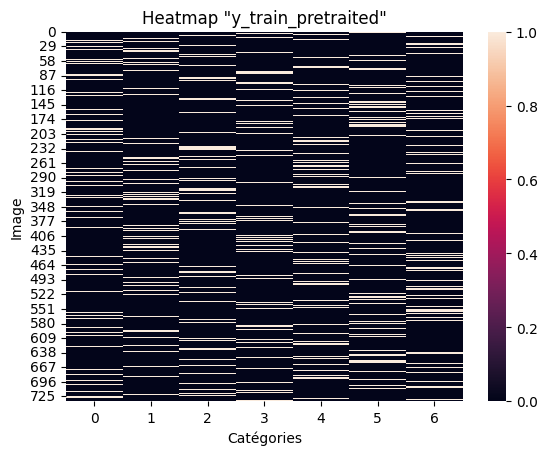

In [29]:
affiche_heatmap(y_train_pretraited, "y_train_pretraited")

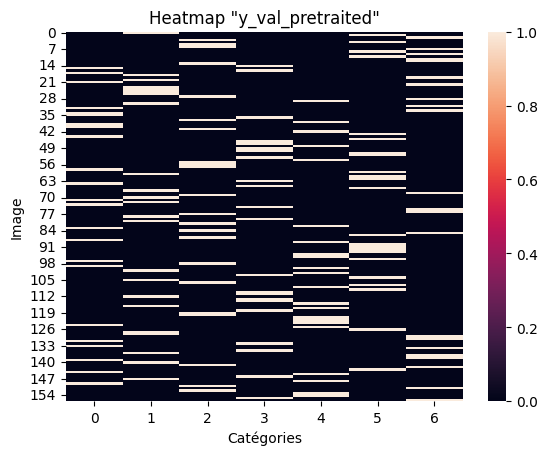

In [30]:
affiche_heatmap(y_val_pretraited, "y_val_pretraited")

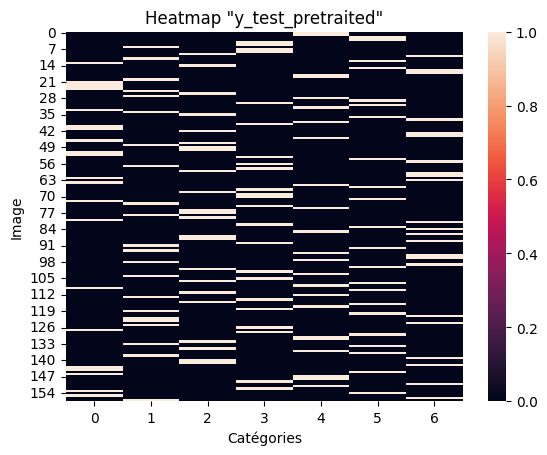

In [31]:
affiche_heatmap(y_test_pretraited, "y_test_pretraited")

### <span style='background:black'>b/ features</span>

Le prétraitement des features pour le **MLP** se déroule en plusieurs étapes :
- Redimensionnement de l'images en 224 x 224 pixels
- Convertion de l'image en tableau NumPy
- Certification des dimensions (hauteur, largeur, couleur)

In [32]:
# Prétraitement jeu entrainement
X_train_pretraited = pretraitement_image(X_train, 'mlp')

# Prétraitement jeu validation
X_val_pretraited = pretraitement_image(X_val, 'mlp')

# Prétraitement jeu test
X_test_pretraited = pretraitement_image(X_test, 'mlp')

Nous vérifions les dimensions des images pour vérifier que le prétraitement des features a bien été réalisé.

In [33]:
print("X_train_pretraited : ", X_train_pretraited.shape)
print("X_val_pretraited : ", X_val_pretraited.shape)
print("X_test_pretraited : ", X_test_pretraited.shape)

X_train_pretraited :  (735, 224, 224, 3)
X_val_pretraited :  (157, 224, 224, 3)
X_test_pretraited :  (158, 224, 224, 3)


## <span style='background:green'>2/ Elaboration du modèle</span>

### <span style='background:black'>a/ Architecture</span>

Le modèle MLP présente la structure suivante :
- 1 couche d'entrée de forme (224, 224, 3)
- 1 couche Flatten pour aplatir les données d'entrée
- 2 couches Dense avec 10 neurones chacune et 1 fonction d'activation ReLU
- 1 couche Dense avec 7 neurones et une fonction d'activation sofmax

### <span style='background:black'>b/ Compilation et métrique d'évaluation</span>

Le modèle est compilé avec :
- la fonction de perte '**categorical_crossentropy**' qui est adaptée à la classification multiclasse où les étiquettes sont codées en OneHotEncoder.

- l'optimiseur '**rmsprop**' qui est un algoritme d'optimisation intéressant pour les réseaux de neurones profonds.

- la métrique d'évaluation '**accuracy**' qui est une métrique très utilisée pour les problèmes de classification. Elle mesure le pourcentage de prédictions correctes du modèle. Sa principale limite est de présenter une image  trompeuse de la perfomance du modèle si les classes sont déséquilibrées, ce qui n'est pas le cas ici puisque nos 7 classes sont parfaitement équilibrées (150 images par classe).

In [34]:
fonction_perte = 'categorical_crossentropy'
optimiseur = 'rmsprop'
metric_eval = 'accuracy'


### <span style='background:black'>c/ Callbacks</span>

Les callbacks sont des fonctions qui sont appelées à des moments précis de
l'entrainement du modèle pour effectuer des actions spécifiques.

Nous créons 2 callbacks :
- **ModelCheckpoint** pour sauvegarder le meilleur modèle pendant l'entrainement. Cela permet de conserver les poids du modèle qui a présenté les meilleures performances (perte du jeu de validation la plus petite) même si le modèle commence à se détériorer ou à surapprendre par la suite.

- **EarlyStopping** pour arrêter l'entrainement si val_loss (la perte du jeu de validation) ne diminue plus après 3 epochs. Cela permet de gagner du temps d'entrainement et d'éviter de surapprendre le modèle pour avoir une meilleure généralisation.

In [35]:
# Nombre d'epochs pour la patience
patience = 3

### <span style='background:black'>d/ Indicateur supplémentaire</span>

Pour comparer les performances des différents modèles, nous utilisons un indicateur supplémentaire pour améliorer notre prise de décision en mesurant le **temps de calcul nécessaire pour l'entrainement du modèle.** En effet, l'accuracy seule ne suffit pas à déterminer le meilleur modèle, il faut également que celui-ci réalise ses calculs en un minimun de temps.

=> Le choix de l'indicateur est donc un compromis entre l'accuracy et le temps de calcul.

### <span style='background:black'>e/ Optimisation hyperparamètre</span>

Nous déterminons le meilleur modèle en ajustant l'hyperparamètre **batch_size** (nombre d'images par lot utilisées pour chaque mise à jour du modèle) mais nous fixons le nombre d'epochs :
- epochs = 15
- batch_size = 32, 64, 128 et 256

In [36]:
# Définir les batch_sizes à tester
batch_sizes = [32, 64, 128, 256]

# SI fichier des resultats existe ALORS on passe
if is_modele_mlp_calculed:
    print("Les calculs ont deja tournés sur Google Colab")

# SINON il n'existe pas et il faut faire les calculs
else:

    # Créer des dictionnaires vides pour stocker l'historique, temps, epochs
    history_dict, time_dict, epoch_dict = {}, {}, {}

    # POUR chaque batch_size
    for batch_size in batch_sizes:
        print("\n", "=" * 30, "batch_size :", batch_size, "=" * 30)

        # Créer un modèle MLP
        model_mlp = creation_modele_mlp(
            fonction_perte,
            optimiseur,
            metric_eval
        )

        # Création des callbacks
        callbacks_list, chemin_modele_export = creer_callbacks(
            "model_mlp",
            patience,
            batch_size
        )

        # Enregistrer le temps de début
        start_time = time.time()

        # Entraîner le modèle
        history_mlp = model_mlp.fit(
            X_train_pretraited,
            y_train_pretraited,
            epochs=15,
            batch_size=batch_size,
            callbacks=callbacks_list,
            validation_data=(X_val_pretraited, y_val_pretraited),
            verbose=0
        )

        # Enregistrer le temps de fin
        end_time = time.time()

        # Calculer le temps d'entraînement
        temps_train = end_time - start_time
        print(f"\n=> Temps d'entraînement : {round(temps_train, 2)} sec <=")

        # Calculer le nombre d'epochs
        epochs = len(history_mlp.history['loss'])

        # Stocker l'historique, le temps d'entraînement et le nombre d'epochs
        history_dict[batch_size] = history_mlp.history
        time_dict[batch_size] = temps_train
        epoch_dict[batch_size] = epochs

Les calculs ont deja tournés sur Google Colab


Comparons les résultats obtenus pour les différents batch_size :

In [37]:
# SI fichier des resultats existe ALORS on passe
if is_modele_mlp_calculed:
    print("Les calculs ont deja tournés sur Google Colab")

# SINON il n'existe pas et il faut faire les calculs
else:
    resultat_mlp = creer_dataframe_resultats(
        history_dict,
        time_dict,
        epoch_dict,
        batch_sizes,
        "resultat_mlp"
    )

# Afficher le batch_size avec la meilleure accuracy de validation
batch_meilleur_mlp = resultat_mlp.loc[
    resultat_mlp['Validation Accuracy'].idxmax(),
    'batch_size'
]
print(f"\nMeilleur batch_size (accuracy): {batch_meilleur_mlp}")

# Surligner les meilleures valeurs
resultat_mlp.style.apply(surligne_meilleur)

Les calculs ont deja tournés sur Google Colab

Meilleur batch_size (accuracy): 128


,Validation Accuracy,Temps (sec),Epochs,batch_size
0,0.140127,13.971376,15,32
1,0.140127,11.278276,15,64
2,0.146497,8.965965,11,128
3,0.140127,9.892615,15,256


Les meilleurs performances sont obtenues pour un batch_size de 128 (accuracy de validation la plus grande et temps de calcul le plus faible).

Nous choississons donc le **batch_size de 128** pour la suite des analyses avec le **MLP**.

## <span style='background:green'>3/ Modèle optimal</span>

### <span style='background:black'>a/Création et entrainement</span>

Nous entrainons à nouveau le modèle avec le bon batch_size pour obtenir le modèle optimal.

In [38]:
# SI fichier des resultats existe ALORS on passe
if is_modele_mlp_calculed:
    print("Les calculs ont deja tournés sur Google Colab")

# SINON on realise les calculs
else:
    print("On fait les calculs.")

    # Créer le modèle optimal MLP
    model_optimal_mlp = creation_modele_mlp(
        fonction_perte,
        optimiseur,
        metric_eval,
        verbose=1
    )

    # Création des callbacks
    callbacks_list, chemin_modele_export = creer_callbacks(
        "model_optimal_mlp",
        patience
    )

    # Enregistrer le temps de début
    start_time = time.time()

    # Entraîner le modèle avec batch__meilleur_mlp
    history_optimal_mlp = model_optimal_mlp.fit(
        X_train_pretraited,
        y_train_pretraited,
        epochs=15,
        batch_size=batch_meilleur_mlp,
        callbacks=callbacks_list,
        validation_data=(X_val_pretraited, y_val_pretraited),
        verbose=1
    )

    # Enregistrer le temps de fin
    end_time = time.time()

    # Calculer le temps d'entraînement
    temps_train = end_time - start_time
    print(f"\n=> Temps d'entraînement : {round(temps_train, 2)} sec <=")

    # Calculer le nombre d'epochs
    epochs = len(history_optimal_mlp.history['loss'])

    # Créer un dictionnaire pour stocker historique, temps et nombre d'époch
    history_optimal_mlp_dict = {
        'history': history_optimal_mlp.history,
        'temps_train': temps_train,
        'num_epochs': epochs
    }

    # Sauvegarder l'objet history_dict
    with open("./modele_ML/history_optimal_mlp.pickle", 'wb') as f:
        pickle.dump(history_optimal_mlp_dict, f)

Les calculs ont deja tournés sur Google Colab


Nous regroupons les résultats obtenus par notre modele optimal en 1 ligne.

In [39]:
# Récuperation des résultats
resultat_optimal_mlp = creer_dataframe_optimal(
    history_optimal_mlp_dict,
    batch_meilleur_mlp,
    'mlp'
)

display(resultat_optimal_mlp)

,Validation Accuracy,Temps (sec),Epochs,batch_size
mlp,0.14,10.54,15,128


### <span style='background:black'>b/ Plot loss et accuracy</span>

Nous affichons l'évolution de la perte et de l'accuracy pour le jeu d'entrainement et le jeu de test au cours des epochs.

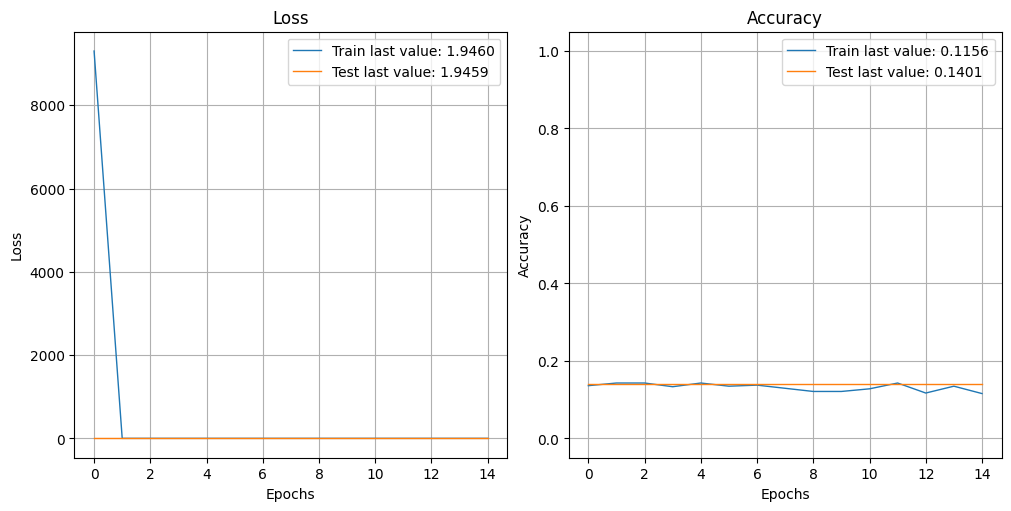

In [40]:
# Afficher l'historique de l'entraînement
show_history(history_optimal_mlp_dict['history'])

# Definir le chemin d'export de la figure
dossier_figure = "./figure/"
nom_figure = "history_optimal_mlp.png"
chemin_figure_export = os.path.join(dossier_figure, nom_figure)

# Sauvegarder le plot de l'historique de l'entraînement
plot_history(history_optimal_mlp_dict, path=chemin_figure_export)
plt.close()

Nous remarquons que le modèle présente une perte de validation élevée (1,94) et une accuracy de validation faible (< 0,2).

### <span style='background:black'>c/ Comparatif des accuracy</span>

Nous comparons les accuracy du modèle optimal (MLP) avec les poids du meilleur modèle pour les 2 jeux de données (entrainement et test).

In [41]:
# Charger les poids du meilleur modèle
model_optimal_mlp.load_weights("./modele_ML/model_optimal_mlp_best_weights.h5")

# Evaluation meilleur modèle sur les données d'entraînement
loss_mlp_train, accuracy_mlp_train = model_optimal_mlp.evaluate(
    X_train_pretraited,
    y_train_pretraited
)
print("Training Accuracy   :  {:.3f}".format(accuracy_mlp_train))

# Evaluation meilleur modèle sur les données de test
loss_mlp_test, accuracy_mlp_test = model_optimal_mlp.evaluate(
    X_test_pretraited,
    y_test_pretraited
)
print("Test Accuracy       :  {:.3f}".format(accuracy_mlp_test))

23/23 [==============================] - 1s 3ms/step - loss: 1.9459 - accuracy: 0.1429
Training Accuracy   :  0.143
5/5 [==============================] - 0s 3ms/step - loss: 1.9459 - accuracy: 0.1456
Test Accuracy       :  0.146


Les 2 accuracy sont proches mais faibles (< 0,15).

### <span style='background:black'>d/ Matrice de confusion</span>

Nous affichons les valeurs réelles et celles prédites par le modèle optimal pour les données de validation.

In [42]:
# Categorie réelle et prédites des images de validation
y_val_num = np.argmax(y_val_pretraited, axis=1)
y_val_pred = np.argmax(model_optimal_mlp.predict(
    X_val_pretraited), axis=1)

# Afficher les 30 premières catégories réelles et prédites
print("Categorie reelle : ", y_val_num[:30], "\n")
print("Categorie prédite : ", y_val_pred[:30])

5/5 [==============================] - 0s 3ms/step
Categorie reelle :  [1 5 6 2 5 2 2 6 5 6 5 6 6 2 3 0 3 0 1 6 1 0 6 1 1 1 1 2 6 4] 

Categorie prédite :  [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


Il semblerait que le modèle optimal MLP n'a fait que prédire une seule catégorie pour toutes les images de validation.

In [43]:
# Créer un DataFrame à partir de y_val_pred
y_val_pred_df = pd.DataFrame(y_val_pred, columns=['categorie_predite'])

# Obtenir le nombre de chaque valeur unique
unique_counts = y_val_pred_df['categorie_predite'].value_counts()

# Obtenir le pourcentage de chaque valeur unique
unique_percentages = y_val_pred_df['categorie_predite'].value_counts(
    normalize=True) * 100

# Créer un DataFrame pour afficher les résultats
result = pd.DataFrame({
    'Nombre': unique_counts,
    'Pourcentage': unique_percentages
})

# Afficher les résultats
display(result)
print(f"La seul categorie predite est : {categories[unique_counts.index[0]]}")

,Nombre,Pourcentage
categorie_predite,,
4,157,100.0


La seul categorie predite est : Kitchen & Dining 


Nous confirmons les résultats en affichant la matrice de confusion et le rapport de classification.


Correspondance des clusters :  [0 0 0 0 0 0 0]


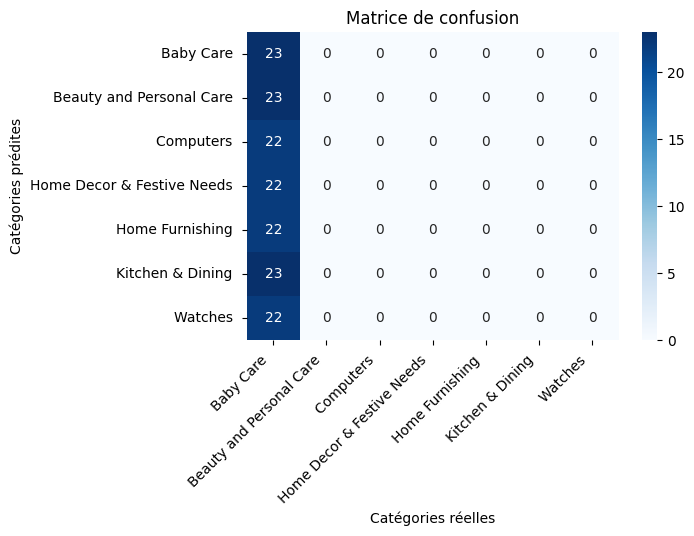

              precision    recall  f1-score   support

           0       0.15      1.00      0.26        23
           1       1.00      0.00      0.00        23
           2       1.00      0.00      0.00        22
           3       1.00      0.00      0.00        22
           4       1.00      0.00      0.00        22
           5       1.00      0.00      0.00        23
           6       1.00      0.00      0.00        22

    accuracy                           0.15       157
   macro avg       0.88      0.14      0.04       157
weighted avg       0.87      0.15      0.04       157



In [44]:
# Verifier la correspondance des clusters
y_val_pred_transform = conf_mat_transform_argmax(y_val_num, y_val_pred)

# Afficher la matrice de confusion et le rapport de classification
conf_mat_mlp = matrice_conf_et_rapport(
    y_val_num,
    y_val_pred_transform,
    categories
    )

Le modèle optimal MLP presente un f-score < 0,16.

<div class="alert alert-block alert-success"><b>Bilan: </b> <br>
Le modèle optimal MLP présente des performances très faibles qui sont équivalentes à un classifieur naïf en ne prédisant qu'une seule catégorie. </div>

# <span style='background:blue'>Etape 5 : CNN</span>

Pour cette classification d'image automatique, nous allons utiliser un Convolutionnal Neural Network (**CNN**).

## <span style='background:green'>1/ Prétraitement des données</span>

### <span style='background:black'>a/ target</span>

Nous utilisons le même prétraitement de la target que précedemment. Pour rappel, il consiste à transformer les catégories avec un **OneHotEncoder** pour pouvoir les utiliser dans le modèle de machine learning.

### <span style='background:black'>b/ features</span>

Nous utilisons le même prétraitement des features que précedemment. Pour rappel, il se déroule en plusieurs étapes :
- Redimensionnement de l'images en 224 x 224 pixels
- Convertion de l'image en tableau NumPy
- Certification des dimensions (hauteur, largeur, couleur)

## <span style='background:green'>2/ Elaboration du modèle</span>

### <span style='background:black'>a/ Architecture</span>

Le modèle CNN présente la structure suivante :
- 1 couche de convolution avec 32 filtres de taille 3 x 3 et une fonction d'activation ReLU
- 1 couche de pooling avec un filtre de taille 2 x 2
- 1 couche de flatten pour applatir les sorties des couches précédentes en un vecteur
- 1 couche dense avec 56 neurones et une fonction d'activation ReLU
- 1 couche de sortie avec 7 neurones et une fonction d'activation softmax

### <span style='background:black'>b/ Compilation et métrique d'évaluation</span>

Le modèle est compilé avec les mêmes paramètres que précedemment, à savoir :
- la fonction de perte '**categorical_crossentropy**'

- l'optimiseur '**rmsprop**'

- la métrique d'évaluation '**accuracy**'

### <span style='background:black'>c/ Callbacks</span>

Nous utilisons les mêmes callbacks que précedemment, à savoir :

- **ModelCheckpoint** pour sauvegarder le meilleur modèle pendant l'entrainement.

- **EarlyStopping** pour arrêter l'entrainement si val_loss (la perte du jeu de validation) ne diminue plus après 3 epochs.

### <span style='background:black'>d/ Indicateur supplémentaire</span>

Nous utilisons le même indicateur supplémentaire que précedemment, à savoir le **temps de calcul**.

### <span style='background:black'>e/ Optimisation hyperparamètre</span>

Nous utilisont les mêmes paramètres que précedemment, à savoir :
- epochs = 15
- batch_size = 32, 64, 128 et 256

In [45]:
# SI fichier des resultats existe ALORS on passe
if is_modele_cnn_calculed:
    print("Les calculs ont deja tournés sur Google Colab")

# SINON il n'existe pas et il faut faire les calculs
else:
    # Créer des dictionnaires vides pour stocker l'historique, temps, epochs
    history_dict, time_dict, epoch_dict = {}, {}, {}

    # POUR chaque batch_size
    for batch_size in batch_sizes:
        print("\n", "=" * 30, "batch_size :", batch_size, "=" * 30)

        # Créer un modèle CNN
        model_cnn = creation_modele_cnn(
            fonction_perte,
            optimiseur,
            metric_eval
            )

        # Création des callbacks
        callbacks_list, chemin_modele_export = creer_callbacks(
            "model_cnn",
            patience,
            batch_size
            )

        # Enregistrer le temps de début
        start_time = time.time()

        # Entraîner le modèle
        history_cnn = model_cnn.fit(
            X_train_pretraited,
            y_train_pretraited,
            epochs=15,
            batch_size=batch_size,
            callbacks=callbacks_list,
            validation_data=(X_val_pretraited, y_val_pretraited),
            verbose=0
            )

        # Enregistrer le temps de fin
        end_time = time.time()

        # Calculer le temps d'entraînement
        temps_train = end_time - start_time
        print(f"\n=> Temps d'entraînement : {round(temps_train, 2)} sec <=")

        # Calculer le nombre d'epochs
        epochs = len(history_cnn.history['loss'])

        # Stocker l'historique, le temps d'entraînement et le nombre d'epochs
        history_dict[batch_size] = history_cnn.history
        time_dict[batch_size] = temps_train
        epoch_dict[batch_size] = epochs

Les calculs ont deja tournés sur Google Colab


Comparons les résultats obtenus pour les différents batch_size :

In [46]:
# SI fichier des resultats existe ALORS on passe
if is_modele_cnn_calculed:
    print("Les calculs ont deja tournés sur Google Colab")

# SINON il n'existe pas et il faut faire les calculs
else:
    resultat_cnn = creer_dataframe_resultats(
        history_dict,
        time_dict,
        epoch_dict,
        batch_sizes,
        "resultat_cnn"
    )

# Afficher le batch_size avec la meilleure accuracy de validation
batch_meilleur_cnn = resultat_cnn.loc[
    resultat_cnn['Validation Accuracy'].idxmax(),
    'batch_size'
]
print(f"\nMeilleur batch_size (accuracy): {batch_meilleur_cnn}")

# Surligner les meilleures valeurs
resultat_cnn.style.apply(surligne_meilleur)

Les calculs ont deja tournés sur Google Colab

Meilleur batch_size (accuracy): 64


,Validation Accuracy,Temps (sec),Epochs,batch_size
0,0.140127,36.849359,8,32
1,0.426752,36.910836,9,64
2,0.299363,55.144984,15,128
3,0.222930,27.912522,7,256


Les meilleurs performances sont obtenues pour un batch_size de 64 (accuracy de validation la plus grande et temps de calcul intermédiaire). Le temps de calcul le plus faible est obtenu avec le batch de 256 mais son accuracy de validation est nettement plus faible.

Nous choississons donc le **batch_size de 64** pour la suite des analyses avec le **CNN**.

## <span style='background:green'>3/ Modèle optimal</span>

### <span style='background:black'>a/Création et entrainement</span>

Nous entrainons à nouveau le modèle avec le bon batch_size pour obtenir le modèle optimal.

In [48]:
# SI fichier des resultats existe ALORS on passe
if is_modele_cnn_calculed:
    print("Les calculs ont deja tournés sur Google Colab")

# SINON on realise les calculs
else:
    print("On fait les calculs.")

    # Créer le modèle optimal CNN
    model_optimal_cnn = creation_modele_cnn(
        fonction_perte,
        optimiseur,
        metric_eval,
        verbose=1
    )

    # Création des callbacks
    callbacks_list, chemin_modele_export = creer_callbacks(
        "model_optimal_cnn",
        patience
    )

    # Enregistrer le temps de début
    start_time = time.time()

    # Entraîner le modèle avec batch_meilleur_cnn
    history_optimal_cnn = model_optimal_cnn.fit(
        X_train_pretraited,
        y_train_pretraited,
        epochs=15,
        batch_size=batch_meilleur_cnn,
        callbacks=callbacks_list,
        validation_data=(X_val_pretraited, y_val_pretraited),
        verbose=1
    )

    # Enregistrer le temps de fin
    end_time = time.time()

    # Calculer le temps d'entraînement
    temps_train = end_time - start_time
    print(f"\n=> Temps d'entraînement : {round(temps_train, 2)} sec <=")

    # Calculer le nombre d'epochs
    epochs = len(history_optimal_cnn.history['loss'])

    # Créer un dictionnaire pour stocker historique, temps et nombre d'époch
    history_optimal_cnn_dict = {
        'history': history_optimal_cnn.history,
        'temps_train': temps_train,
        'num_epochs': epochs
    }

    # Sauvegarder l'objet history_dict
    with open("./modele_ML/history_optimal_cnn.pickle", 'wb') as f:
        pickle.dump(history_optimal_cnn_dict, f)

Les calculs ont deja tournés sur Google Colab


Nous regroupons les résultats obtenus par notre modele optimal en 1 ligne.

In [49]:
# Récuperation des résultats
resultat_optimal_cnn = creer_dataframe_optimal(
    history_optimal_cnn_dict,
    batch_meilleur_cnn,
    'cnn'
)

display(resultat_optimal_cnn)

,Validation Accuracy,Temps (sec),Epochs,batch_size
cnn,0.17,62.15,15,64


### <span style='background:black'>b/ Plot loss et accuracy</span>

Nous affichons l'évolution de la perte et de l'accuracy pour le jeu d'entrainement et le jeu de validation au cours des epoch.

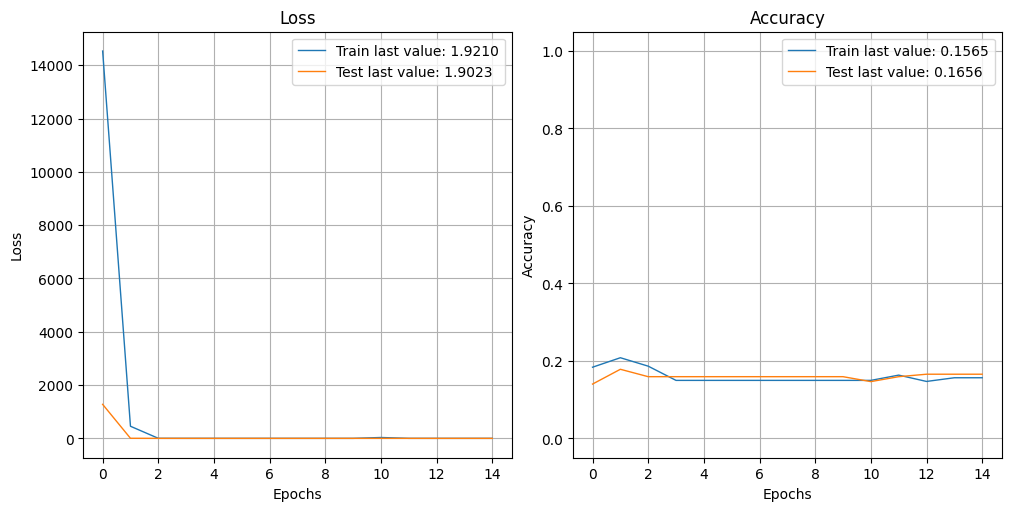

In [50]:
# Afficher l'historique de l'entraînement
show_history(history_optimal_cnn_dict['history'])

# Definir le chemin d'export de la figure
dossier_figure = "./figure/"
nom_figure = "history_optimal_cnn.png"
chemin_figure_export = os.path.join(dossier_figure, nom_figure)

# Sauvegarder l'historique de l'entraînement
plot_history(history_optimal_cnn_dict, path=chemin_figure_export)
plt.close()

Nous remarquons que les résultats ne sont pas à la hauteur des attentes espérées suite à l'optimisation des hyperparamètres. Le modèle présente une perte de validation élevée (1,90) et une accuracy de validation faible (< 0,2).

### <span style='background:black'>c/ Comparatif des accuracy</span>

Nous comparons les accuracy du modèle optimal (CNN) avec les poids du meilleur modèle pour les 2 jeux de données (entrainement et test).

In [51]:
# Charger les poids du meilleur modèle
model_optimal_cnn.load_weights("./modele_ML/model_optimal_cnn_best_weights.h5")

# Evaluation meilleur modèle sur les données d'entraînement
loss_cnn_train, accuracy_cnn_train = model_optimal_cnn.evaluate(
    X_train_pretraited,
    y_train_pretraited
)
print("Training Accuracy   :  {:.3f}".format(accuracy_cnn_train))

# Evaluation meilleur modèle sur les données de test
loss_cnn_test, accuracy_cnn_test = model_optimal_cnn.evaluate(
    X_test_pretraited,
    y_test_pretraited
)
print("Test Accuracy       :  {:.3f}".format(accuracy_cnn_test))

23/23 [==============================] - 3s 82ms/step - loss: 1.9207 - accuracy: 0.1565
Training Accuracy   :  0.156
5/5 [==============================] - 0s 86ms/step - loss: 1.9336 - accuracy: 0.1519
Test Accuracy       :  0.152


Les 2 accuracy sont proches mais faibles (< 0,16).

### <span style='background:black'>d/ Matrice de confusion</span>

Nous affichons les valeurs réelles et celles prédites par le modèle optimal pour les données de validation.

In [52]:
# Categories prédites des images de validation
y_val_pred = np.argmax(model_optimal_cnn.predict(X_val_pretraited), axis=1)

# Afficher les 30 premières catégories réelles et prédites
print("Categorie reelle : ", y_val_num[:30], "\n")
print("Categorie prédite : ", y_val_pred[:30])

5/5 [==============================] - 0s 55ms/step
Categorie reelle :  [1 5 6 2 5 2 2 6 5 6 5 6 6 2 3 0 3 0 1 6 1 0 6 1 1 1 1 2 6 4] 

Categorie prédite :  [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


Nous confirmons les résultats en affichant la matrice de confusion et le rapport de classification.


Correspondance des clusters :  [0 0 2 0 0 5 0]


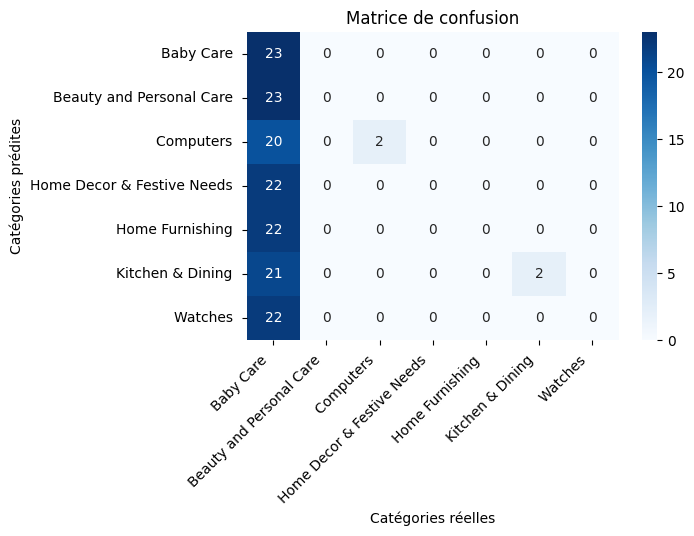

              precision    recall  f1-score   support

           0       0.15      1.00      0.26        23
           1       1.00      0.00      0.00        23
           2       1.00      0.09      0.17        22
           3       1.00      0.00      0.00        22
           4       1.00      0.00      0.00        22
           5       1.00      0.09      0.16        23
           6       1.00      0.00      0.00        22

    accuracy                           0.17       157
   macro avg       0.88      0.17      0.08       157
weighted avg       0.88      0.17      0.09       157



In [53]:
# Verifier la correspondance des clusters
y_val_pred_transform = conf_mat_transform_argmax(y_val_num, y_val_pred)

# Afficher la matrice de confusion et le rapport de classification
conf_mat_cnn = matrice_conf_et_rapport(
    y_val_num,
    y_val_pred_transform,
    categories
    )

Le modèle optimal CNN presente un f-score < 0,18.

<div class="alert alert-block alert-success"><b>Bilan: </b> <br>
Le modèle optimal CNN présente des performances très faibles qui sont équivalentes à un classifieur naïf et le modèle optimal MLP en ne prédisant presque tout le temps qu'une seule catégorie. </div>

# <span style='background:blue'>Etape 6 : CNN + Transfer learning VGG-16</span>

Pour cette classification d'image automatique, nous allons utiliser un **réseau de neurones convolutionnels** (*Convolutional Neural Network*, **CNN**). Nous le couplons avec la technique du **transfer learning** pour utiliser le modèle pré-entrainé **VGG-16**.

Le modèle VGG-16 a été entrainé sur un jeu de données ImageNet de plus d'1 million d'images.

## <span style='background:green'>1/ Prétraitement des données</span>

### <span style='background:black'>a/ target</span>

Nous utilisons le même prétraitement de la target que précedemment. Pour rappel, il consiste à transformer les catégories avec un **OneHotEncoder** pour pouvoir les utiliser dans le modèle de machine learning.

### <span style='background:black'>b/ features</span>

Le prétraitement des features pour le **VGG16** se déroule en plusieurs étapes :
- Redimensionnement de l'images en 224 x 224 pixels
- Convertion de l'image en tableau NumPy
- Certification des dimensions (hauteur, largeur, couleur)
- Normaliser les pixels de l'image pour VGG16 :
  - Mettre à l'echelle entre -1 et 1 (soustraire valeur moyenne des
    des pixels sur le canaux RGB du jeu de données ImageNet)
  - inverser les canaux RGB en BGR

In [54]:
# Prétraitement jeu entrainement
X_train_pretraited = pretraitement_image(X_train, 'vgg16')

# Prétraitement jeu validation
X_val_pretraited = pretraitement_image(X_val, 'vgg16')

# Prétraitement jeu test
X_test_pretraited = pretraitement_image(X_test, 'vgg16')

Nous vérifions les dimensions des images pour vérifier que le prétraitement des features a bien été réalisé.

In [55]:
print("X_train_pretraited : ", X_train_pretraited.shape)
print("X_val_pretraited : ", X_val_pretraited.shape)
print("X_test_pretraited : ", X_test_pretraited.shape)

X_train_pretraited :  (735, 224, 224, 3)
X_val_pretraited :  (157, 224, 224, 3)
X_test_pretraited :  (158, 224, 224, 3)


## <span style='background:green'>2/ Elaboration du modèle</span>

### <span style='background:black'>a/ Architecture</span>

Le modèle VGG16 est composé de 16 couches de convolution et de 3 couches fully connected. Il classe les images (224 x 224 pixels) en 1000 catégories différentes.

Nous créons un modèle de classification d'images CNN en réalisant un **transfer learning** à partir du modèle VGG16. Ce dernier est importé **sans** les 3 couches fully connected. Les **poids** du modèle sont initialisés
avec les poids du modèle entrainé sur ImageNet.

Le modèle de transfer learning VGG16 est utilisé comme extracteur de caractéristiques, et 4 nouvelles couches sont ajoutées à sa sortie :
- 1 couche de **GlobalAveragePooling2D** pour convertir les features en un vecteur 1D
- 1 couche **Dense** de 256 neurones et une fonction d'activation **relu**
- 1 couche **Dropout** pour désactiver 50% des neurones
- 1 couche **Dense**
de 7 neurones et une fonction d'activation **softmax** pour la classification

### <span style='background:black'>b/ Compilation et métrique d'évaluation</span>

Le modèle est compilé avec les mêmes paramètres que précedemment, à savoir :
- la fonction de perte '**categorical_crossentropy**'

- l'optimiseur '**rmsprop**'

- la métrique d'évaluation '**accuracy**'

### <span style='background:black'>c/ Callbacks</span>

Nous utilisons les mêmes callbacks que précedemment, à savoir :

- **ModelCheckpoint** pour sauvegarder le meilleur modèle pendant l'entrainement.

- **EarlyStopping** pour arrêter l'entrainement si val_loss (la perte du jeu de validation) ne diminue plus après 3 epochs.

### <span style='background:black'>d/ Indicateur supplémentaire</span>

Nous utilisons le même indicateur supplémentaire que précedemment, à savoir le **temps de calcul**.

### <span style='background:black'>e/ Optimisation hyperparamètre</span>

Nous utilisont les mêmes paramètres que précedemment, à savoir :
- epochs = 15
- batch_size = 32, 64, 128 et 256

In [56]:
# SI fichier des resultats existe ALORS on passe
if is_modele_tf_vgg16_noDA_calculed:
    print("Les calculs ont deja tournés sur Google Colab")

# SINON il n'existe pas et il faut faire les calculs
else:

    # Créer des dictionnaires vides pour stocker l'historique, temps, epochs
    history_dict, time_dict, epoch_dict = {}, {}, {}

    # POUR chaque batch_size
    for batch_size in batch_sizes:
        print("\n", "=" * 30, "batch_size :", batch_size, "=" * 30)

        # Créer un modèle CNN avec transfert learning (VGG16)
        model_tf_vgg16_noDA = creation_modele_transfer_vgg16(
            fonction_perte,
            optimiseur,
            metric_eval,
            verbose=0
        )

        # Création des callbacks
        callbacks_list, chemin_modele_export = creer_callbacks(
            "model_tf_vgg16_noDA",
            patience,
            batch_size
        )

        # Enregistrer le temps de début
        start_time = time.time()

        # Entraîner le modèle
        history_tf_vgg16_noDA = model_tf_vgg16_noDA.fit(
            X_train_pretraited,
            y_train_pretraited,
            epochs=15,
            batch_size=batch_size,
            callbacks=callbacks_list,
            validation_data=(X_val_pretraited, y_val_pretraited),
            verbose=0
        )

        # Enregistrer le temps de fin
        end_time = time.time()

        # Calculer le temps d'entraînement
        temps_train = end_time - start_time
        print(f"\n=> Temps d'entraînement : {round(temps_train, 2)} sec <=")

        # Calculer le nombre d'epochs
        epochs = len(history_tf_vgg16_noDA.history['loss'])

        # Stocker l'historique, le temps d'entraînement et le nombre d'epochs
        history_dict[batch_size] = history_tf_vgg16_noDA.history
        time_dict[batch_size] = temps_train
        epoch_dict[batch_size] = epochs

Les calculs ont deja tournés sur Google Colab


Comparons les résultats obtenus pour les différents batch_size :

In [57]:
# SI fichier des resultats existe ALORS on passe
if is_modele_tf_vgg16_noDA_calculed:
    print("Les calculs ont deja tournés sur Google Colab")

# SINON il n'existe pas et il faut faire les calculs
else:
    resultat_tf_vgg16_noDA = creer_dataframe_resultats(
        history_dict,
        time_dict,
        epoch_dict,
        batch_sizes,
        "resultat_tf_vgg16_noDA"
    )

# Afficher le batch_size avec la meilleure accuracy de validation
batch_meilleur_tf_vgg16_noDA = resultat_tf_vgg16_noDA.loc[
    resultat_tf_vgg16_noDA['Validation Accuracy'].idxmax(),
    'batch_size'
]
print(f"\nMeilleur batch_size (accuracy): {batch_meilleur_tf_vgg16_noDA}")

# Surligner les meilleures valeurs
resultat_tf_vgg16_noDA.style.apply(surligne_meilleur)

Les calculs ont deja tournés sur Google Colab

Meilleur batch_size (accuracy): 32


,Validation Accuracy,Temps (sec),Epochs,batch_size
0,0.834395,87.498551,9,32
1,0.796178,68.602543,7,64
2,0.802548,74.762772,8,128
3,0.777070,91.626898,10,256


Les meilleurs performances sont obtenues pour un batch_size de 32 (accuracy de validation la plus grande et temps de calcul intermédiaire). Le temps de calcul le plus faible est obtenu avec le batch de 256 mais l'écart de temps entre les 2 n'est pas très important (20% env.), nous préferons favoriser l'accuracy de validation.

Nous choississons donc le **batch_size de 32** pour la suite des analyses avec le **CNN avec Transfer Learning VGG16**.

## <span style='background:green'>3/ Modèle optimal</span>

### <span style='background:black'>a/Création et entrainement</span>

Nous entrainons à nouveau le modèle avec le bon batch_size pour obtenir le modèle optimal.

In [58]:
# SI fichier des resultats existe ALORS on passe
if is_modele_tf_vgg16_noDA_calculed:
    print("Les calculs ont deja tournés sur Google Colab")

# SINON on realise les calculs
else:
    print("On fait les calculs.")

    # Créer le modèle optimal de tranfer learning VGG16
    model_optimal_tf_vgg16_noDA = creation_modele_transfer_vgg16(
        fonction_perte,
        optimiseur,
        metric_eval,
        verbose=1
    )

    # Création des callbacks
    callbacks_list, chemin_modele_export = creer_callbacks(
        "model_optimal_tf_vgg16_noDA",
        patience
    )

    # Enregistrer le temps de début
    start_time = time.time()

    # Entraîner le modèle avec batch_meilleur_tf_vgg16_noDA
    history_optimal_tf_vgg16_noDA = model_optimal_tf_vgg16_noDA.fit(
        X_train_pretraited,
        y_train_pretraited,
        epochs=15,
        batch_size=batch_meilleur_tf_vgg16_noDA,
        callbacks=callbacks_list,
        validation_data=(X_val_pretraited, y_val_pretraited),
        verbose=1
    )

    # Enregistrer le temps de fin
    end_time = time.time()

    # Calculer le temps d'entraînement
    temps_train = end_time - start_time
    print(f"\n=> Temps d'entraînement : {round(temps_train, 2)} sec <=")

    # Calculer le nombre d'epochs
    epochs = len(history_optimal_tf_vgg16_noDA.history['loss'])

    # Créer un dictionnaire pour stocker historique, temps et nombre d'époch
    history_optimal_tf_vgg16_noDA_dict = {
        'history': history_optimal_tf_vgg16_noDA.history,
        'temps_train': temps_train,
        'num_epochs': epochs
    }

    # Sauvegarder l'objet history_dict
    with open("./modele_ML/history_optimal_tf_vgg16_noDA.pickle", 'wb') as f:
        pickle.dump(history_optimal_tf_vgg16_noDA_dict, f)

Les calculs ont deja tournés sur Google Colab


Nous regroupons les résultats obtenus par notre modele optimal en 1 ligne.

In [59]:
# Récuperation des résultats
resultat_optimal_tf_vgg16_noDA = creer_dataframe_optimal(
    history_optimal_tf_vgg16_noDA_dict,
    batch_meilleur_tf_vgg16_noDA,
    'tf_vgg16_noDA'
)

display(resultat_optimal_tf_vgg16_noDA)

,Validation Accuracy,Temps (sec),Epochs,batch_size
tf_vgg16_noDA,0.77,80.94,8,32


### <span style='background:black'>b/ Plot loss et accuracy</span>

Nous affichons l'évolution de la perte et de l'accuracy pour le jeu d'entrainement et le jeu de validation au cours des epoch.

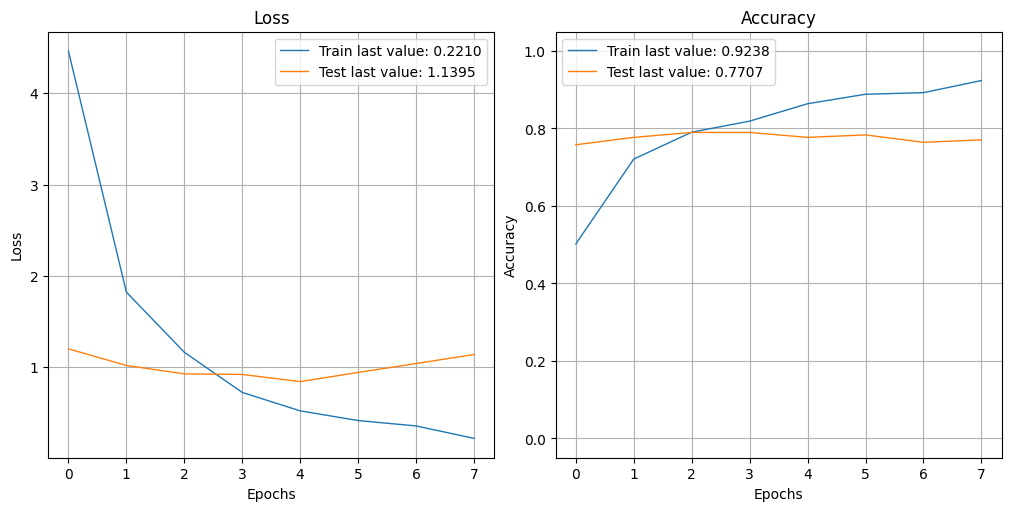

In [60]:
# Afficher l'historique de l'entraînement
show_history(history_optimal_tf_vgg16_noDA_dict['history'])

# Définir le chemin d'export de la figure
dossier_figure = "./figure/"
nom_figure = "history_optimal_tf_vgg16_noDA.png"
chemin_figure_export = os.path.join(dossier_figure, nom_figure)

# Sauvegarder l'historique de l'entraînement
plot_history(history_optimal_tf_vgg16_noDA_dict, path=chemin_figure_export)
plt.close()

Nous remarquons que le modèle présente une perte de validation convenable (<1,2), ce qui est un bon indicateur de la qualité du modèle. De plus, nous remarquons que l'accuracy de test est convenable (> 0,75).

En revanche, ce modèle présente présente un **surapprentissage** puisque son accuracy d'entrainement est nettement plus élevée (> 0,90) que celle de test.

### <span style='background:black'>c/ Comparatif des accuracy</span>

Nous comparons les accuracy du modèle optimal (Transfer learning avec VGG16) avec les poids du meilleur modèle pour les 2 jeux de données (entrainement et test).

In [61]:
# Charger les poids du meilleur modèle
model_optimal_tf_vgg16_noDA.load_weights(
    "./modele_ML/model_optimal_tf_vgg16_noDA_best_weights.h5"
)

# Evaluation meilleur modèle sur les données d'entraînement
loss_tf_vgg16_noDA_train, accuracy_tf_vgg16_noDA_train = (
    model_optimal_tf_vgg16_noDA.evaluate(
        X_train_pretraited,
        y_train_pretraited
    )
)
print("Training Accuracy   :  {:.3f}".format(accuracy_tf_vgg16_noDA_train))

# Evaluation meilleur modèle sur les données de test
loss_tf_vgg16_noDA_test, accuracy_tf_vgg16_noDA_test = (
    model_optimal_tf_vgg16_noDA.evaluate(
        X_test_pretraited,
        y_test_pretraited
    )
)
print("Test Accuracy       :  {:.3f}".format(accuracy_tf_vgg16_noDA_test))

23/23 [==============================] - 51s 2s/step - loss: 0.0994 - accuracy: 0.9714
Training Accuracy   :  0.971
5/5 [==============================] - 11s 2s/step - loss: 0.6935 - accuracy: 0.7911
Test Accuracy       :  0.791


L'accuracy d'entrainement est nettement plus élévé (> 0,95) que l'accuracy de test (< 0,80).

### <span style='background:black'>d/ Matrice de confusion</span>

Nous affichons les valeurs réelles et celles prédites par le modèle optimal pour les données de validation.

In [62]:
# Categorie réelle et prédites des images de validation
y_val_num = np.argmax(y_val_pretraited, axis=1)
y_val_pred = np.argmax(
    model_optimal_tf_vgg16_noDA.predict(X_val_pretraited),
    axis=1
)

# Afficher les 30 premières catégories réelles et prédites
print("Categorie reelle : ", y_val_num[:30], "\n")
print("Categorie prédite : ", y_val_pred[:30])

5/5 [==============================] - 11s 2s/step
Categorie reelle :  [1 5 6 2 5 2 2 6 5 6 5 6 6 2 3 0 3 0 1 6 1 0 6 1 1 1 1 2 6 4] 

Categorie prédite :  [1 5 6 2 5 2 2 6 5 6 5 6 6 2 3 0 3 0 1 6 1 0 6 2 1 1 1 2 6 4]


Nous confirmons les résultats en affichant la matrice de confusion et le rapport de classification.


Correspondance des clusters :  [0 1 2 3 4 5 6]


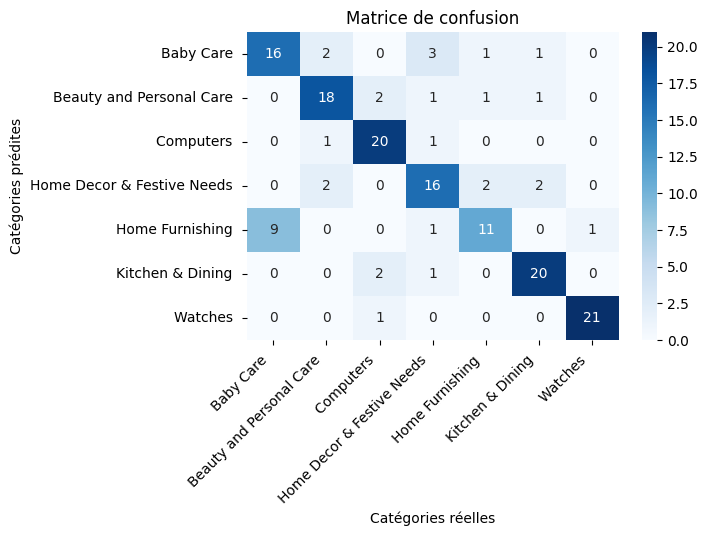

              precision    recall  f1-score   support

           0       0.64      0.70      0.67        23
           1       0.78      0.78      0.78        23
           2       0.80      0.91      0.85        22
           3       0.70      0.73      0.71        22
           4       0.73      0.50      0.59        22
           5       0.83      0.87      0.85        23
           6       0.95      0.95      0.95        22

    accuracy                           0.78       157
   macro avg       0.78      0.78      0.77       157
weighted avg       0.78      0.78      0.77       157



In [63]:
# Verifier la correspondance des clusters
y_val_pred_transform = conf_mat_transform_argmax(y_val_num, y_val_pred)

# Afficher la matrice de confusion et le rapport de classification
conf_mat_tf_vgg16_noDA = matrice_conf_et_rapport(
    y_val_num,
    y_val_pred_transform,
    categories
    )

Le modèle optimal CNN avec Transfer Learning VGG16 presente un f-score > 0,75.

<div class="alert alert-block alert-success"><b>Bilan: </b> <br>
Le modèle optimal CNN avec transfer learning du VGG16 présente des performances supérieures à tous les autres modèles. Il est relativement précis mais il présente un surapprentissage qui se traduit par une généralisation médiocre qui peut-être encore optimisée . </div>

# <span style='background:blue'>Etape 7 : Comparaison des résultats</span>

Nous standardisons le format des résultats pour les comparer.

In [64]:
# Concaténer les trois DataFrames
resultat_optimal_tous = pd.concat(
    [
        resultat_optimal_mlp,
        resultat_optimal_cnn,
        resultat_optimal_tf_vgg16_noDA
    ], ignore_index=False
)

display(resultat_optimal_tous)

,Validation Accuracy,Temps (sec),Epochs,batch_size
mlp,0.14,10.54,15,128
cnn,0.17,62.15,15,64
tf_vgg16_noDA,0.77,80.94,8,32


4:5: E128 continuation line under-indented for visual indent
5:5: E128 continuation line under-indented for visual indent


In [65]:
# Surligner les meilleures valeurs
resultat_optimal_tous.style.apply(surligne_meilleur)

,Validation Accuracy,Temps (sec),Epochs,batch_size
mlp,0.140127,10.536837,15,128
cnn,0.165605,62.145483,15,64
tf_vgg16_noDA,0.770701,80.939456,8,32


<div class="alert alert-block alert-success"><b>Bilan: </b> <br>
Le modèle <b>CNN couplé avec le transfer Learning VGG16</b> est le seul modèle a présenter des performances convenables. Malgré un temps de calcul plus élévé, il demeure la meilleure solution envisageable pour notre classification d'image supervisée avec du deep learning. </div>

# <span style='background:blue'>Etape 8 : CNN + Transfer learning VGG-16 avec Data Augmentation</span>

Pour cette classification d'image automatique, nous allons utiliser le CNN avec Transfer Learning VGG16. Nous optimisons les performances du modèle en utilisant la technique de **data augmentation**.

<div class="alert alert-block alert-info"><b>Note informative: </b> <br>
A la différence des autres modèles qui ont été exécutés sur Google Colab pour obtenir des temps de calcul plus courts, ce modèle n'a pas pu être éxécuté sur Google Colab pour des problème d'accès aux images pendant la création du 'flow' de la data augmentation. Voici le message d'erreur obtenu lors de son exécution sur Google Colab :<br>

*failed to connect to all addresses; last error: UNKNOW: ipv4:127.0.0.1:36043: Failed to connect to remote host: Connection refused {gprc_status:14, created_time:"2024-02-08T17:55:33.249468843+00:00"}[[{{node IteratorGetNext}}]]* <div>

Ce modèle a donc été exécuté et entrainé sur notre CPU local. Les temps de calculs ne sont donc pas comparables car les ressources computationnelles ne sont pas comparables avec celles des TPU de Google Colab. </iv>

## <span style='background:green'>1/ Prétraitement des données</span>

### <span style='background:black'>a/ target</span>

Nous utilisons le même prétraitement de la target que précedemment. Pour rappel, il consiste à transformer les catégories avec un **OneHotEncoder** pour pouvoir les utiliser dans le modèle de machine learning.

### <span style='background:black'>b/ features</span>

Le prétraitement des features pour le **VGG16** se déroule en plusieurs étapes :
- Redimensionnement de l'images en 224 x 224 pixels
- Convertion de l'image en tableau NumPy
- Certification des dimensions (hauteur, largeur, couleur)
- Normaliser les pixels de l'image pour VGG16 :
  - Mettre à l'echelle entre -1 et 1 (soustraire valeur moyenne des
    des pixels sur le canaux RGB du jeu de données ImageNet)
  - inverser les canaux RGB en BGR

## <span style='background:green'>2/ Elaboration du modèle de data augmentation</span>

La technique de **data augmentation** consiste à générer des images supplémentaires à partir des images d'entrainement en les modifiant légèrement. Cela permet d'augmenter la taille du jeu de données d'entrainement et d'améliorer les performances du modèle. Pour cela, nous utilisons la fonction **ImageDataGenerator** de Keras.

Nous créons un générateur d'images d'entrainement et de validation avec les paramètres suivants :
- Centrer les données (soustraction de la moyenne des pixels)
- Normaliser les données (division par l'écart-type des pixels)
- Rotation aléatoire de l'image de +- 20 degrés
- Translation aléatoire de l'image de +- 20% de la largeur de l'image
- Translation aléatoire de l'image de +- 20% de la hauteur de l'image
- Retournement horizontal aléatoire de l'image
- Modification de la luminosité aléatoire de l'image dans la plage de 50% à 100% de la luminosité originale
- Zoom aléatoire de l'image de 30% à 150% de la taille originale    

## <span style='background:green'>3/ Modèle optimal</span>

Nous entrainons directement le modèle optimal obtenu précédemment avec le CNN avec Transfer Learning VGG16. Nous utilisons également les mêmes paramètres que précedemment, à savoir :
- epochs = 15
- batch_size = 32 (batch_size modèle optimal CNN avec Transfer Learning VGG16)
- callbacks : ModelCheckpoint et EarlyStopping
- indicateurs supplémentaires : temps de calcul

### <span style='background:black'>a/Création et entrainement</span>

Nous entrainons à nouveau le modèle avec le bon batch_size pour obtenir le modèle optimal.

In [67]:
# Définir le batch_size de la data augmentation
batch_da = batch_meilleur_tf_vgg16_noDA

# SI fichier des resultats existe ALORS on passe
if is_modele_tf_vgg16_DA_calculed:
    print("Les calculs ont deja tournés sur PC en local.")

# SINON on realise les calculs
else:
    print("On fait les calculs.")

    # Créer un générateur de données avec Data Augmentation
    datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        brightness_range=(0.5, 1.),
        zoom_range=(0.3, 1.5)
    )

    # Entrainer le générateur sur les données d'entraînement
    datagen.fit(X_train_pretraited)

    # Créer le modèle optimal de tranfer learning VGG16
    model_optimal_tf_vgg16_DA = creation_modele_transfer_vgg16(
        fonction_perte,
        optimiseur,
        metric_eval,
    )

    # Créer le flux d'entraînement avec Data Augmentation
    train_flow = datagen.flow(
        X_train_pretraited,
        y_train_pretraited,
        batch_size=batch_da
    )

    # Créer le flux de validation avec Data Augmentation
    val_flow = datagen.flow(
        X_val_pretraited,
        y_val_pretraited,
        batch_size=batch_da
    )

    # Création des callbacks
    callbacks_list, chemin_modele_export = creer_callbacks(
        "model_optimal_tf_vgg16_DA",
        patience
    )

    # Enregistrer le temps de début
    start_time = time.time()

    # Entraîner le modèle avec batch_meilleur_tf_vgg16_DA
    history_optimal_tf_vgg16_DA = model_optimal_tf_vgg16_DA.fit(
        train_flow,
        validation_data=val_flow,
        epochs=15,
        callbacks=callbacks_list,
        verbose=1
    )

    # Enregistrer le temps de fin
    end_time = time.time()

    # Calculer le temps d'entraînement
    temps_train = end_time - start_time
    print(f"\n=> Temps d'entraînement : {round(temps_train, 2)} sec <=")

    # Calculer le nombre d'epochs
    epochs = len(history_optimal_tf_vgg16_DA.history['loss'])

    # Créer un dictionnaire pour stocker historique, temps et nombre d'époch
    history_optimal_tf_vgg16_DA_dict = {
        'history': history_optimal_tf_vgg16_DA.history,
        'temps_train': temps_train,
        'num_epochs': epochs
    }

    # Sauvegarder l'objet history
    with open('./modele_ML/history_optimal_tf_vgg16_DA.pickle', 'wb') as f:
        pickle.dump(history_optimal_tf_vgg16_DA_dict, f)

On fait les calculs.
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.7402 - accuracy: 0.3456
Epoch 1: val_loss improved from inf to 1.39717, saving model to ./modele_ML\model_optimal_tf_vgg16_DA_best_weights.h5
23/23 [==============================] - 63s 3s/step - loss: 1.7402 - accuracy: 0.3456 - val_loss: 1.3972 - val_accuracy: 0.5860
Epoch 2/15


c:\Users\pierr\VSC_Projects\Projet6_OCR_DataScientist-\env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - ETA: 0s - loss: 1.3617 - accuracy: 0.5442
Epoch 2: val_loss improved from 1.39717 to 1.15093, saving model to ./modele_ML\model_optimal_tf_vgg16_DA_best_weights.h5
23/23 [==============================] - 61s 3s/step - loss: 1.3617 - accuracy: 0.5442 - val_loss: 1.1509 - val_accuracy: 0.6688
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 1.1820 - accuracy: 0.5959
Epoch 3: val_loss improved from 1.15093 to 1.04503, saving model to ./modele_ML\model_optimal_tf_vgg16_DA_best_weights.h5
23/23 [==============================] - 60s 3s/step - loss: 1.1820 - accuracy: 0.5959 - val_loss: 1.0450 - val_accuracy: 0.6815
Epoch 4/15
 9/23 [==========>...................] - ETA: 29s - loss: 1.1300 - accuracy: 0.6146

23/23 [==============================] - ETA: 0s - loss: 1.0802 - accuracy: 0.6313
Epoch 4: val_loss improved from 1.04503 to 0.99404, saving model to ./modele_ML\model_optimal_tf_vgg16_DA_best_weights.h5
23/23 [==============================] - 58s 3s/step - loss: 1.0802 - accuracy: 0.6313 - val_loss: 0.9940 - val_accuracy: 0.7134
Epoch 5/15
23/23 [==============================] - ETA: 0s - loss: 1.0263 - accuracy: 0.6612
Epoch 5: val_loss improved from 0.99404 to 0.91840, saving model to ./modele_ML\model_optimal_tf_vgg16_DA_best_weights.h5
23/23 [==============================] - 58s 3s/step - loss: 1.0263 - accuracy: 0.6612 - val_loss: 0.9184 - val_accuracy: 0.7134
Epoch 6/15
23/23 [==============================] - ETA: 0s - loss: 0.9802 - accuracy: 0.6558
Epoch 6: val_loss improved from 0.91840 to 0.88696, saving model to ./modele_ML\model_optimal_tf_vgg16_DA_best_weights.h5
23/23 [==============================] - 57s 2s/step - loss: 0.9802 - accuracy: 0.6558 - val_loss: 0.8870

Nous regroupons les résultats obtenus par notre modele optimal en 1 ligne.

In [68]:
# Récuperation des résultats
resultat_optimal_tf_vgg16_DA = creer_dataframe_optimal(
    history_optimal_tf_vgg16_DA_dict,
    batch_da,
    'tf_vgg16_DA'
)

display(resultat_optimal_tf_vgg16_DA)

,Validation Accuracy,Temps (sec),Epochs,batch_size
tf_vgg16_DA,0.74,866.47,15,32


### <span style='background:black'>b/ Plot loss et accuracy</span>

Nous affichons l'évolution de la perte et de l'accuracy pour le jeu d'entrainement et le jeu de validation au cours des epoch.

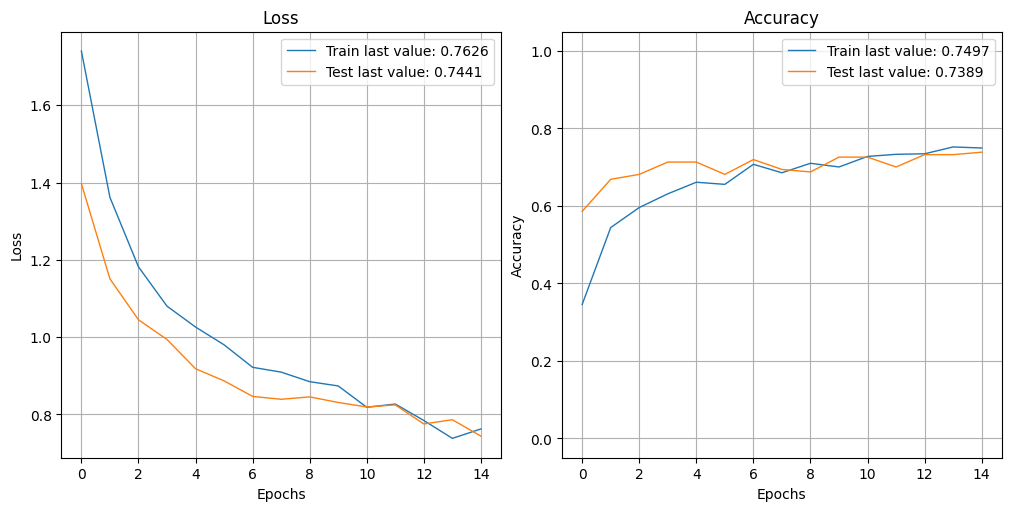

In [69]:
# Afficher l'historique de l'entraînement
show_history(history_optimal_tf_vgg16_DA_dict['history'])

# Definir le chemin d'export de la figure
dossier_figure = "./figure/"
nom_figure = "history_optimal_tf_vgg16_DA.png"
chemin_figure_export = os.path.join(dossier_figure, nom_figure)

# Sauvegarder l'historique de l'entraînement
plot_history(history_optimal_tf_vgg16_DA_dict, path=chemin_figure_export)
plt.close()

Nous remarquons que le modèle présente une perte de validation faible (<1), ce qui est un bon indicateur de la qualité du modèle. De plus, nous remarquons que l'accuracy de test est convenable (> 0,73). De plus, ce modèle ne présente présente **pas de surapprentissage** puisque son accuracy d'entrainement est équivalente à celle de test.

La data augmentation a permis d'améliorer les performances du modèle en atténuant nettement le surapprentissage.

### <span style='background:black'>c/ Comparatif des accuracy</span>

Nous comparons les accuracy du modèle optimal (Transfer learning avec VGG16) avec les poids du meilleur modèle pour les 2 jeux de données (entrainement et test).

In [70]:
# Charger les poids du meilleur modèle
model_optimal_tf_vgg16_DA.load_weights(
    "./modele_ML/model_optimal_tf_vgg16_DA_best_weights.h5"
)

# Evaluation meilleur modèle sur les données d'entraînement
loss_tf_vgg16_DA_train, accuracy_tf_vgg16_DA_train = (
    model_optimal_tf_vgg16_DA.evaluate(
        X_train_pretraited,
        y_train_pretraited
    )
)
print("Training Accuracy   :  {:.3f}".format(accuracy_tf_vgg16_DA_train))

# Evaluation meilleur modèle sur les données de test
loss_tf_vgg16_DA_test, accuracy_tf_vgg16_DA_test = (
    model_optimal_tf_vgg16_DA.evaluate(
        X_test_pretraited,
        y_test_pretraited
    )
)
print("Test Accuracy       :  {:.3f}".format(accuracy_tf_vgg16_DA_test))

10/23 [============>.................] - ETA: 27s - loss: 7.0631 - accuracy: 0.7969

23/23 [==============================] - 47s 2s/step - loss: 5.9919 - accuracy: 0.8190
Training Accuracy   :  0.819
5/5 [==============================] - 10s 2s/step - loss: 8.3831 - accuracy: 0.7975
Test Accuracy       :  0.797


Les accuracy d'entrainement et de test sont équivalentes et convenables (env. 0,80).

### <span style='background:black'>d/ Matrice de confusion</span>

Nous affichons les valeurs réelles et celles prédites par le modèle optimal pour les données de validation.

In [71]:
# Categorie réelle et prédites des images de validation
y_val_num = np.argmax(y_val_pretraited, axis=1)
y_val_pred = np.argmax(
    model_optimal_tf_vgg16_DA.predict(X_val_pretraited),
    axis=1
)

# Afficher les 30 premières catégories réelles et prédites
print("Categorie reelle : ", y_val_num[:30], "\n")
print("Categorie prédite : ", y_val_pred[:30])

3/5 [=================>............] - ETA: 4s

5/5 [==============================] - 11s 2s/step
Categorie reelle :  [1 5 6 2 5 2 2 6 5 6 5 6 6 2 3 0 3 0 1 6 1 0 6 1 1 1 1 2 6 4] 

Categorie prédite :  [1 5 6 1 5 2 2 6 5 6 3 6 6 2 3 3 3 0 1 6 1 0 6 2 1 1 1 2 6 4]


Nous confirmons les résultats en affichant la matrice de confusion et le rapport de classification.


Correspondance des clusters :  [0 1 2 3 4 5 6]


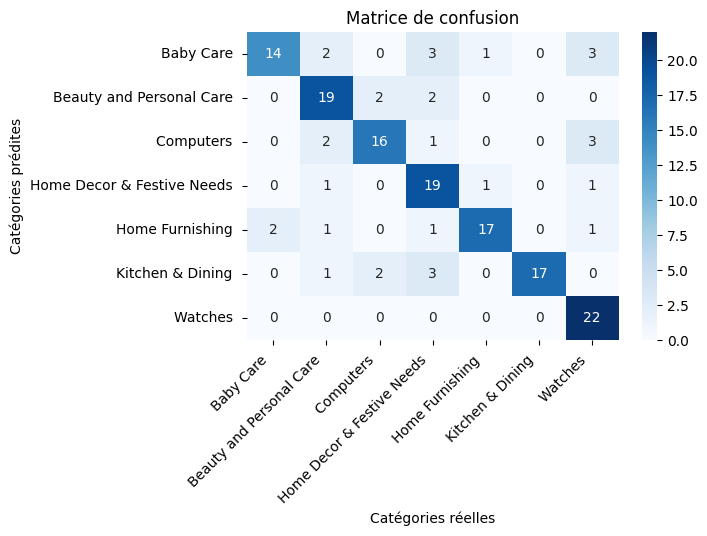

              precision    recall  f1-score   support

           0       0.88      0.61      0.72        23
           1       0.73      0.83      0.78        23
           2       0.80      0.73      0.76        22
           3       0.66      0.86      0.75        22
           4       0.89      0.77      0.83        22
           5       1.00      0.74      0.85        23
           6       0.73      1.00      0.85        22

    accuracy                           0.79       157
   macro avg       0.81      0.79      0.79       157
weighted avg       0.81      0.79      0.79       157



In [72]:
# Verifier la correspondance des clusters
y_val_pred_transform = conf_mat_transform_argmax(y_val_num, y_val_pred)

# Afficher la matrice de confusion et le rapport de classification
conf_mat_tf_vgg16_DA = matrice_conf_et_rapport(
    y_val_num,
    y_val_pred_transform,
    categories
    )

Le modèle optimal CNN avec Transfer Learning VGG16 couplé à la data ugmentation présente un f-score > 0,75.

<div class="alert alert-block alert-success"><b>Bilan: </b> <br>
Le modèle optimal CNN avec transfer learning du VGG16 couplé avec la Data Augmentation présente des performances équivalentes au même modèle sans data augmentation. Néanmoins, il convient davantage à notre objectif puisqu'il évite le surapprentissage qui été induit par le même modèle sans la data augmentation. </div>

# <span style='background:blue'>Etape 9 : Comparaison des résultats</span>

Nous comparons les résultats obtenus avec les différents modèle de classification d'images pour déterminer le meilleur modèle.

In [73]:
# Concaténer les 4 DataFrames
resultat_optimal_tous = pd.concat(
    [
        resultat_optimal_mlp,
        resultat_optimal_cnn,
        resultat_optimal_tf_vgg16_noDA,
        resultat_optimal_tf_vgg16_DA
    ], ignore_index=False
)
display(resultat_optimal_tous)

,Validation Accuracy,Temps (sec),Epochs,batch_size
mlp,0.14,10.54,15,128
cnn,0.17,62.15,15,64
tf_vgg16_noDA,0.77,80.94,8,32
tf_vgg16_DA,0.74,866.47,15,32


In [74]:
# Surligner les meilleures valeurs
resultat_optimal_tous.style.apply(surligne_meilleur)

,Validation Accuracy,Temps (sec),Epochs,batch_size
mlp,0.140127,10.536837,15,128
cnn,0.165605,62.145483,15,64
tf_vgg16_noDA,0.770701,80.939456,8,32
tf_vgg16_DA,0.738854,866.473519,15,32


Nous ne pouvons pas nous prononcer sur les temps de calculs de la data augmentation en comparaison des autres modèles car les ressources computationnelles ne sont pas comparables avec celles utilisées pour entrainer les autres modèles (TPU Google Colab).

Nous partons du principe que le temps de calcul de la data augmentation est assez proche de celui sans data augmentation. 

# <span style='background:blue'>Conclusion</span>

Le meilleur modèle pour effectuer la classification d'images supervisée que nous souhaitons réaliser est le **CNN avec Transfer Learning VGG16** couplé avec la **Data Augmentation**. Ce modèle présente des performances convenables et évite le surapprentissage qui était induit par le même modèle sans la data augmentation.

Il serait préférable de vérifier que les temps de calcul de ce modèle avec la data augmentation sont acceptables pour l'entreprise **Flipkart** avant de le mettre en production.

In [75]:
# Afficher temps d'exécution du notebook
calculer_duree_notebook(start_time)

Durée totale pour faire tourner le notebook : 15 minute(s) 35 seconde(s)
